Version 2025.01.03 - A. Lundervold

Lab 1: using the `elemd219-2025`conda environment 


[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/ELMED219-2025/blob/main/Lab1-NetworkSci-PSN/notebooks/03-patient-similarity-networks-ibs-brain.ipynb)

# Patient similarity networks - ibs-brain

(https://github.com/arvidl/ibs-brain)

#### Data Loading and Path Handling

- Handles both local and Google Colab environments
- Automatically sets up correct paths and downloads data if needed
- Ensures code portability across different environments


#### Data Preprocessing

- Selects numerical columns for analysis
- Handles missing values using mean imputation
- Standardizes features to ensure equal scale importance
- Critical for meaningful similarity calculations


#### Network Creation

- Uses Euclidean distance to measure patient similarity
- Applies Gaussian kernel to convert distances to similarities
- Implements k-nearest neighbors approach to ensure balanced connectivity
- Uses similarity threshold to maintain meaningful connections
- Combines global threshold with local connectivity


#### Network Analysis

- Calculates basic network metrics (nodes, edges, density)
- Computes clustering coefficient to measure patient grouping
- Detects communities using modularity optimization
- Calculates centrality measures to identify key patients
- Provides insights into network structure


#### Network Visualization

- Uses spring layout for natural clustering visualization
- Node sizes reflect degree (number of connections)
- Colors indicate centrality (importance in network)
- Edge transparency shows similarity strength
- Includes colorbar for interpretation
- Optimized for readability and insight



#### Parameters that can be tuned:

- threshold: Controls minimum similarity for connection (0.3 default)
- k_nearest: Number of neighbors to connect (8 default)
- Node size scaling in visualization
- Edge transparency and width
- Layout parameters

#### The result is a network where:

- Similar patients are clustered together
- Node sizes show connectivity
- Colors show centrality/importance
- Communities are visually apparent
- Outliers are meaningfully connected
- Structure is interpretable

#### Import libraries

In [23]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
# StandardScaler: Standardizes features by removing the mean and scaling to unit variance
# Formula: z = (x - μ)/σ
# Used to ensure all features contribute equally to the analysis
# Normalizing your patient features so that variables with different scales 
# (e.g., age vs. test scores) can be compared fairly
from sklearn.preprocessing import StandardScaler
# pdist: Computes pairwise distances between observations in n-dimensional space
# squareform: Converts distance vector to square distance matrix and vice versa
# Example:
#   pdist([1,2], [3,4]) -> [distance]
#   squareform([distance]) -> [[0, distance],
#                             [distance, 0]]
# Computing how similar or different patients are from each other, which is essential for 
# creating the patient similarity network
from scipy.spatial.distance import pdist, squareform


In [24]:
# Step 1: Data Loading and Path Handling with mounting Google Drive
def setup_data_path_mounting():
    """Set up the correct data path whether running locally or in Colab"""
    try:
        # Try to import Google Colab specific module
        # If this succeeds, we're running in Colab
        from google.colab import drive
        
        # Mount Google Drive to access/save files persistently
        drive.mount('/content/drive')
        
        # Create a data directory in Colab's file system
        # -p flag creates parent directories if they don't exist
        !mkdir -p /content/data
        
        # Download the data file from GitHub using wget
        # -O flag specifies the output filename and path
        !wget -O /content/data/demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv https://raw.githubusercontent.com/arvidl/ibs-brain/main/data/demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv
        
        # Return Colab's data directory path
        return '/content/data'
        
    except:
        # If Google Colab import fails, we're running locally
        # Return local path: parent directory + 'data'
        return os.path.join(os.path.dirname(os.getcwd()), 'data')

In [25]:
# Setup data path without mounting Google Drive
def setup_data_path():
    """Set up the correct data path whether running locally or in Colab"""
    try:
        # Try to import Colab-specific module to detect environment
        from google.colab import drive
        
        # If we reach this point, we're in Colab, so:
        # 1. Create a data directory in Colab's temporary file system
        !mkdir -p data
        
        # 2. Download the data file from GitHub
        # -O flag: specify output filename
        !wget -O data/demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv https://raw.githubusercontent.com/arvidl/ibs-brain/main/data/demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv
        
        # 3. Return simple 'data' path for Colab environment
        return 'data'
        
    except:
        # If Colab import fails, we're running locally
        # Return path that points to data directory one level up from current directory
        return os.path.join(os.path.dirname(os.getcwd()), 'data')

In [26]:
# Step 2: Data Preprocessing
def preprocess_data(df):
    """Preprocess the data for network analysis with NaN handling"""
    
    # Substep 1: Select only numerical columns
    # - Uses pandas select_dtypes to filter for numerical columns
    # - Essential because similarity calculations require numerical data
    # - Excludes categorical/text columns that can't be used for similarity
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Substep 2: Handle missing values (NaN)
    # - Uses mean imputation: replaces NaN with column mean
    # - Mean imputation is a simple but effective strategy for missing data
    # - Must handle NaN before scaling to avoid errors
    df_clean = df[numeric_cols].fillna(df[numeric_cols].mean())
    
    # Substep 3: Standardize features using StandardScaler
    # - Transforms each feature to have mean=0 and std=1
    # - Formula: z = (x - μ)/σ
    # - Ensures all features contribute equally regardless of original scale
    # - Critical when features have different units or ranges
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_clean)
    
    # Returns:
    # - scaled_data: preprocessed and standardized numerical data
    # - numeric_cols: list of numerical column names used
    return scaled_data, numeric_cols

In [27]:
# Step 3: Network Creation
def create_similarity_network(scaled_data, threshold=0.5, k_nearest=5):
    """
    Create a similarity network based on patient features and k-nearest neighbors
    where:   Similar patients are connected by edges 
            Edge weights represent similarity strength
            Each patient connects to their k most similar neighbors
    Parameters:
        scaled_data: Preprocessed patient data (output from preprocess_data)
        threshold: Minimum similarity required for connection (default=0.5)
        k_nearest: Number of neighbors to connect to each node (default=5)
    """
    
    # Substep 1: Calculate pairwise distances between all patients
    # - Uses Euclidean distance: sqrt(sum((x1-x2)^2))
    # - pdist creates a condensed distance matrix
    distances = pdist(scaled_data, metric='euclidean')
    
    # Substep 2: Convert distances to similarities using Gaussian kernel
    # - Formula: exp(-d^2 / (2*sigma^2))
    # - sigma is mean distance (adds small epsilon to avoid division by zero)
    # - Transforms distances to similarities in range [0,1]
    sigma = np.mean(distances) + 1e-8
    similarities = np.exp(-distances ** 2 / (2 * sigma ** 2))
    # Convert to square matrix format for easier indexing
    sim_matrix = squareform(similarities)
    
    # Substep 3: Create empty network
    # - Initialize undirected graph
    # - Add nodes for each patient
    G = nx.Graph()
    n_patients = len(scaled_data)
    G.add_nodes_from(range(n_patients))
    
    # Substep 4: Connect nodes based on similarity
    # - For each patient, find k most similar other patients
    # - Only add edge if similarity > threshold
    # - Combines global threshold with local connectivity
    for i in range(n_patients):
        # Get indices of k most similar patients (excluding self)
        neighbors = np.argsort(sim_matrix[i])[-k_nearest-1:-1]
        for j in neighbors:
            if sim_matrix[i,j] > threshold:
                G.add_edge(i, j, weight=sim_matrix[i,j])
    
    # Returns:
    # - G: NetworkX graph with patients as nodes and similarities as edge weights
    # - sim_matrix: Full similarity matrix for potential further analysis
    return G, sim_matrix

In [28]:
# Step 4: Network Analysis
def analyze_network(G):
    """
    Calculate and display comprehensive network metrics
    The input G is a NetworkX graph object that was created by the create_similarity_network() function.
    This function performs three main types of network analysis:
    (1) Basic Network Metrics:
        - Counts nodes (patients) and edges (connections)
        - Calculates average connections per patient
        - Measures network density and clustering
    (2) Community Detection:
        - Identifies groups of closely connected patients
        - Uses modularity optimization to find natural groupings
    (3) Centrality Analysis:
        - Degree centrality shows which patients have most connections
        - Betweenness centrality identifies bridge patients between groups
    The results help understand the network's structure and identify important patients or patient groups.
    """
    
    # Substep 1: Calculate and display basic network statistics
    # - Number of nodes: total patients in network
    # - Number of edges: total connections between patients
    # - Average degree: average number of connections per patient
    # - Network density: proportion of possible connections that exist
    # - Clustering coefficient: measure of patient grouping tendency
    print("\nNetwork Analysis:")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")
    print(f"Network density: {nx.density(G):.3f}")
    print(f"Average clustering coefficient: {nx.average_clustering(G):.3f}")
    
    # Substep 2: Detect communities in the network
    # - Uses greedy modularity optimization algorithm
    # - Groups patients into distinct communities
    # - Communities are groups of densely connected patients
    communities = list(nx.community.greedy_modularity_communities(G))
    print(f"\nNumber of communities detected: {len(communities)}")
    
    # Substep 3: Calculate centrality measures
    # - Degree centrality: how many connections each patient has
    # - Betweenness centrality: how important each patient is for connecting others
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    
    # Returns three key network metrics:
    # - degree_cent: measure of connection counts
    # - betweenness_cent: measure of node importance
    # - communities: detected patient groups
    return degree_cent, betweenness_cent, communities

In [29]:
# Step 5: Network Visualization
def visualize_network(G, node_colors=None, pos=None):
    """
    Enhanced network visualization
    This visualization function creates a network plot where:
    (1) Node size indicates number of connections
    (2) Node color indicates centrality/importance
    (3) Edge thickness shows similarity strength
    (4) Layout groups similar patients together
    (5) Colorbar helps interpret node colors
    The result is an intuitive visualization of patient relationships and network structure.
    """
    
    # Substep 1: Create figure and axis objects
    # - Sets up a large figure size for better visibility
    # - Creates explicit axis for proper colorbar placement
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Substep 2: Calculate node positions if not provided
    # - Uses spring layout algorithm for natural clustering
    # - k parameter controls spacing between nodes
    # - More iterations = more stable layout
    if pos is None:
        pos = nx.spring_layout(G, k=1/np.sqrt(G.number_of_nodes()), iterations=50)
    
    # Substep 3: Calculate node sizes based on degree
    # - Larger nodes = more connections
    # - Add 1 to ensure even disconnected nodes are visible
    degree_dict = dict(G.degree())
    node_sizes = [((v + 1) * 100) for v in degree_dict.values()]
    
    # Substep 4: Set up node colors
    # - Uses provided colors or defaults to degree centrality
    # - Higher values = darker color
    node_colors = list(node_colors.values()) if node_colors else list(nx.degree_centrality(G).values())
    
    # Substep 5: Draw nodes
    # - Size reflects connectivity
    # - Color reflects centrality
    # - Uses viridis colormap
    # - Partial transparency for better visibility
    nx.draw_networkx_nodes(G, pos, 
                          node_size=node_sizes,
                          node_color=node_colors,
                          cmap=plt.cm.viridis,
                          alpha=0.7,
                          ax=ax)
    
    # Substep 6: Draw edges
    # - Width reflects similarity strength
    # - Low opacity to reduce visual clutter
    edge_weights = [G[u][v].get('weight', 0.1) for u,v in G.edges()]
    nx.draw_networkx_edges(G, pos, 
                          alpha=0.2,
                          width=[w*2 for w in edge_weights],
                          ax=ax)
    
    # Substep 7: Add title and remove axis
    plt.title('Patient Similarity Network\n(Node size: degree, Color: centrality)')
    ax.set_axis_off()
    
    # Substep 8: Add colorbar
    # - Shows scale for centrality scores
    # - Properly aligned with main plot
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Centrality Score')
    
    # Substep 9: Adjust layout and display
    plt.tight_layout()
    plt.show()

In [30]:
def create_and_analyze_network(threshold=0.3, k_nearest=8):
    """
    Create and analyze patient similarity network
    
    Parameters:
    -----------
    threshold : float, default=0.3
        Minimum similarity required for connection
        Lower values create more connections
    k_nearest : int, default=8
        Number of nearest neighbors to connect
        Higher values create denser networks
    
    Returns:
    --------
    G : NetworkX graph
        The patient similarity network
    metrics : tuple
        (degree_centrality, betweenness_centrality, communities)
    """
    
    # Step 1: Setup and load data
    # - Sets up correct path for local/Colab environment
    # - Loads patient data from CSV file
    DATA_PATH = setup_data_path()
    DATA_FILE = 'demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv'
    df = pd.read_csv(os.path.join(DATA_PATH, DATA_FILE))
    print(f"Loaded data shape: {df.shape}")

    # Step 2: Preprocess data
    # - Selects numerical features
    # - Handles missing values
    # - Standardizes the data
    scaled_data, feature_cols = preprocess_data(df)
    print(f"\nFeatures used: {len(feature_cols)}")

    # Step 3: Create network
    # - Uses provided threshold and k_nearest parameters
    # - Creates patient similarity network based on feature similarity
    G, similarity_matrix = create_similarity_network(scaled_data, 
                                                   threshold=threshold, 
                                                   k_nearest=k_nearest)

    # Step 4: Analyze network
    # - Calculates network metrics
    # - Detects communities
    # - Computes centrality measures
    metrics = analyze_network(G)
    
    # Step 5: Visualize network
    # - Creates network visualization
    # - Node size shows connectivity
    # - Node color shows centrality
    visualize_network(G, metrics[0])  # Using degree_centrality for colors

    return G, metrics, scaled_data, feature_cols

Loaded data shape: (78, 48)

Features used: 45

Network Analysis:
Number of nodes: 78
Number of edges: 496
Average degree: 12.72
Network density: 0.165
Average clustering coefficient: 0.422

Number of communities detected: 3


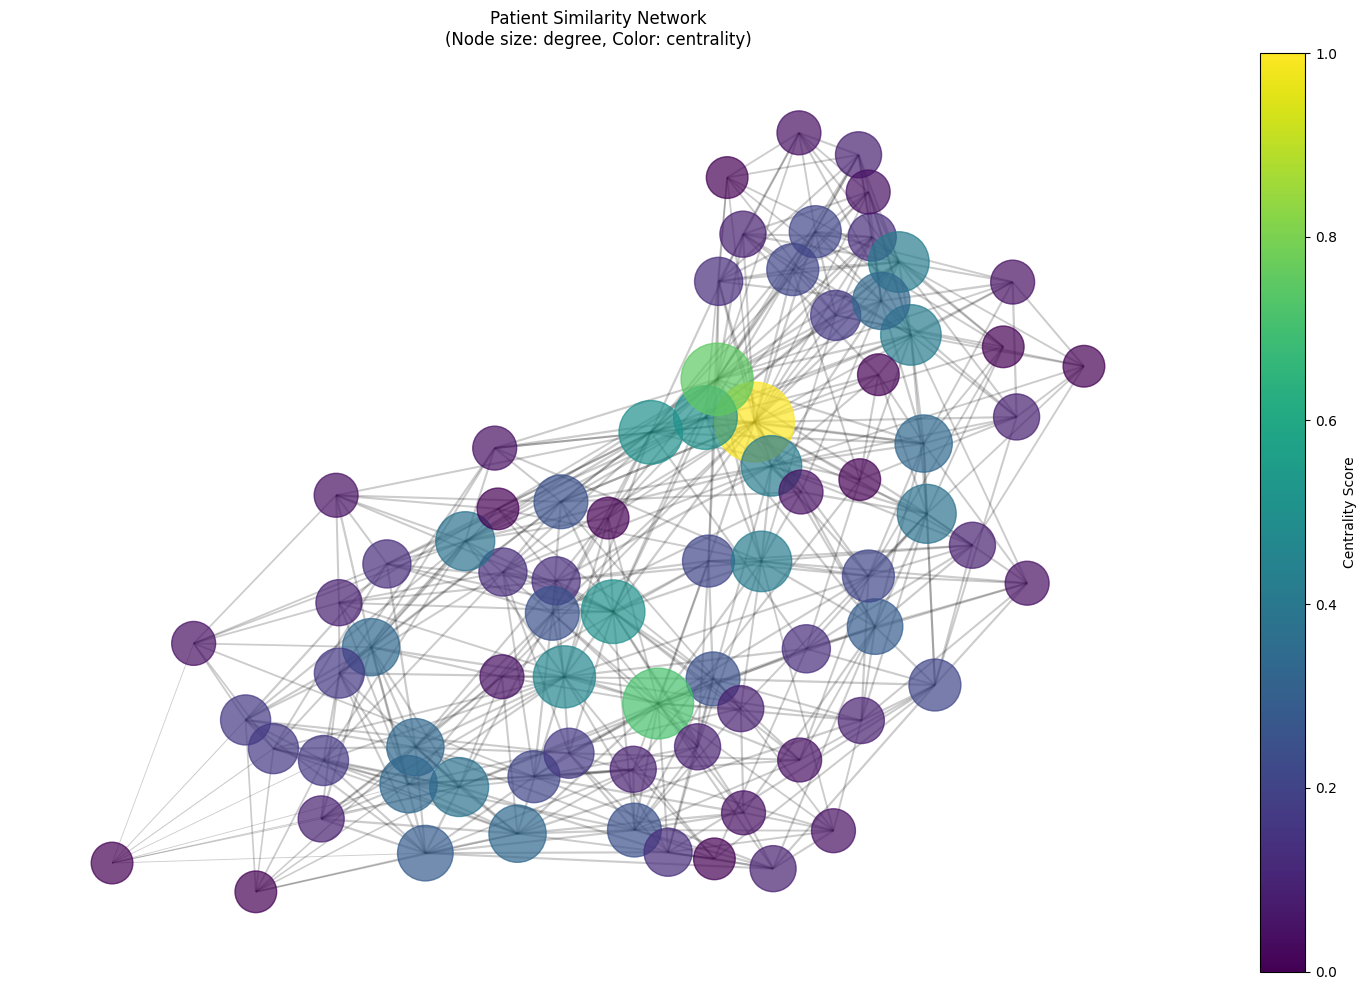

In [31]:
# Example usage:
if __name__ == "__main__":
    # Use default parameters
    G, (degree_cent, between_cent, communities), scaled_data, feature_cols = create_and_analyze_network()
    
    # Or specify custom parameters
    # G, metrics = create_and_analyze_network(threshold=0.4, k_nearest=10)

This Patient Similarity Network visualization reveals several interesting patterns:

1. **Node Characteristics:**
   - Each node represents a patient
   - Node size indicates degree (number of connections)
   - Colors represent centrality (from purple=low to yellow=high)

2. **Network Structure:**
   - There are several hub patients (larger nodes) that are well-connected
   - A few nodes show high centrality (green/yellow) indicating they are important bridge points
   - The network shows clear clustering, suggesting subgroups of similar patients
   - Some peripheral patients (smaller, purple nodes) are less connected

3. **Clinical Implications:**
   - The clusters might represent distinct patient subgroups with similar characteristics
   - The bridge nodes (high centrality) could represent patients with characteristics that span multiple groups
   - The network is well-connected overall, suggesting gradual transitions between patient types
   - Peripheral nodes might represent patients with unique or unusual combinations of characteristics

4. **Network Properties:**
   - The network appears to have good balance between connectivity and structure
   - The chosen threshold and k-nearest neighbor parameters have created meaningful groupings
   - The visualization effectively shows both local connections and global structure

This visualization could help clinicians identify patient subgroups and understand the relationships between different patient characteristics in the dataset.



Similarity statistics:
Min similarity: 0.002
Max similarity: 0.841
Mean similarity: 0.414
Median similarity: 0.426


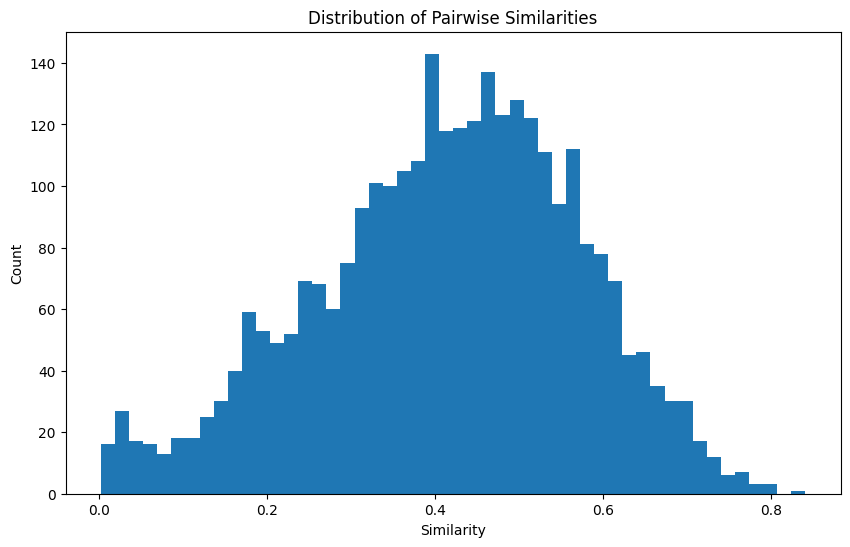

In [32]:
# Analyze similarity distribution
# Step 1: Calculate pairwise distances and convert to similarities
distances = pdist(scaled_data, metric='euclidean')
# Convert distances to similarities using Gaussian kernel
# Formula: exp(-d^2 / mean(d^2))
# This transforms distances into similarity scores between 0 and 1
# - 1 means identical patients
# - 0 means maximally different patients
similarities = np.exp(-distances ** 2 / np.mean(distances ** 2))

# Step 2: Print basic statistics about similarities
print("\nSimilarity statistics:")
print(f"Min similarity: {similarities.min():.3f}")  # Most different pair of patients
print(f"Max similarity: {similarities.max():.3f}")  # Most similar pair of patients
print(f"Mean similarity: {similarities.mean():.3f}")  # Average similarity
print(f"Median similarity: {np.median(similarities):.3f}")  # Middle similarity value

# Step 3: Visualize the distribution of similarities
plt.figure(figsize=(10, 6))
plt.hist(similarities, bins=50)  # Create histogram with 50 bins
plt.title('Distribution of Pairwise Similarities')
plt.xlabel('Similarity')  # 0=different, 1=identical
plt.ylabel('Count')  # Number of patient pairs with this similarity
plt.show()

In [33]:
# Read the data from the CSV file at the ibs-brain repository 

fn = 'demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv'
df = pd.read_csv(f'https://raw.githubusercontent.com/arvidl/ibs-brain/main/data/{fn}')
df


Subject Group          eTIV  Left-Cerebellum-White-Matter  \
0   BGA_046   IBS  1.743419e+06                      0.009292   
1   BGA_047   IBS  1.360311e+06                      0.009960   
2   BGA_048   IBS  1.350452e+06                      0.011099   
3   BGA_050   IBS  1.595000e+06                      0.010458   
4   BGA_051   IBS  1.645577e+06                      0.010128   
..      ...   ...           ...                           ...   
73  BGA_166    HC  1.399586e+06                      0.011516   
74  BGA_167    HC  1.394849e+06                      0.011416   
75  BGA_168    HC  1.259360e+06                      0.012970   
76  BGA_171    HC  1.609011e+06                      0.010545   
77  BGA_172    HC  1.888063e+06                      0.010399   

    Left-Cerebellum-Cortex  Left-Thalamus  Left-Caudate  Left-Putamen  \
0                 0.034808       0.005048      0.002424      0.003358   
1                 0.039399       0.005439      0.002127      0.002992   
2                 0.037770       0.005755      0.002750      0.004094   
3                 0.030902       0.005803      0.002675      0.003622   
4                 0.034373       0.005717      0.002209      0.003332   
..                     ...            ...           ...           ...   
73                0.034967       0.005952      0.002364      0.003272   
74                0.031906       0.005171      0.002180      0.003092   
75                0.041197       0.006277      0.003057      0.004054   
76                0.040919       0.005930      0.002501      0.003863   
77                0.030804       0.004772      0.002155      0.003021   

    Left-Pallidum  Left-Hippocampus  ...  Fullscale_RBANS  Memory_Index  \
0        0.001248          0.003099  ...              100            80   
1        0.001318          0.002999  ...              116           109   
2        0.001498          0.003533  ...               95            83   
3        0.001322          0.002925  ...               87            86   
4        0.001317          0.002864  ...              100           105   
..            ...               ...  ...              ...           ...   
73       0.001358          0.002845  ...               93            89   
74       0.001154          0.002759  ...               97            83   
75       0.001500          0.003182  ...              100           100   
76       0.001624          0.002967  ...               96            89   
77       0.001034          0.002341  ...              123           105   

    Visuospatial_Index  Verbalskills_Index  Attention_Index  Recall_Index  \
0                  102                  93               97            86   
1                  107                  97              115           126   
2                   84                 113              103           100   
3                   97                  90               98            86   
4                   90                  97              108           100   
..                 ...                 ...              ...           ...   
73                  90                 118              108            82   
74                  85                 116              113            23   
75                 103                 107               86           104   
76                 102                  85              101           110   
77                 114                  95              155           107   

    IBS_SSS  Age  Gender  Education  
0     195.0   38       M       12.0  
1     325.0   19       F       13.0  
2     326.0   34       F       13.0  
3     357.0   44       F       18.0  
4     293.0   38       M       18.0  
..      ...  ...     ...        ...  
73     56.0   19       F        NaN  
74     25.0   52       F        NaN  
75     21.0   50       F        NaN  
76     32.0   21       M        NaN  
77     53.0   58       F        NaN  

[78 rows x 48 columns]

_With the information in data frame df, modify the steps Step 1, ..., Step 5 such that the similarity is based only on the morphometric variables and the cognitive variables, excluding Subject, Group, IBS_SSS, Age, Gender and Education._

_For the visualization in Step 5, mark each node with subject number and gender  (e.g. BGA_046 -> 46/M , ..., BGA_172 -> 172/F) and let nodes having Group == IBS be marked with a square-shaped node and Group == HC be circle-shaped._

Features used: 42

Network Analysis:
Number of nodes: 78
Number of edges: 495
Average degree: 12.69
Network density: 0.165
Average clustering coefficient: 0.420

Number of communities detected: 3


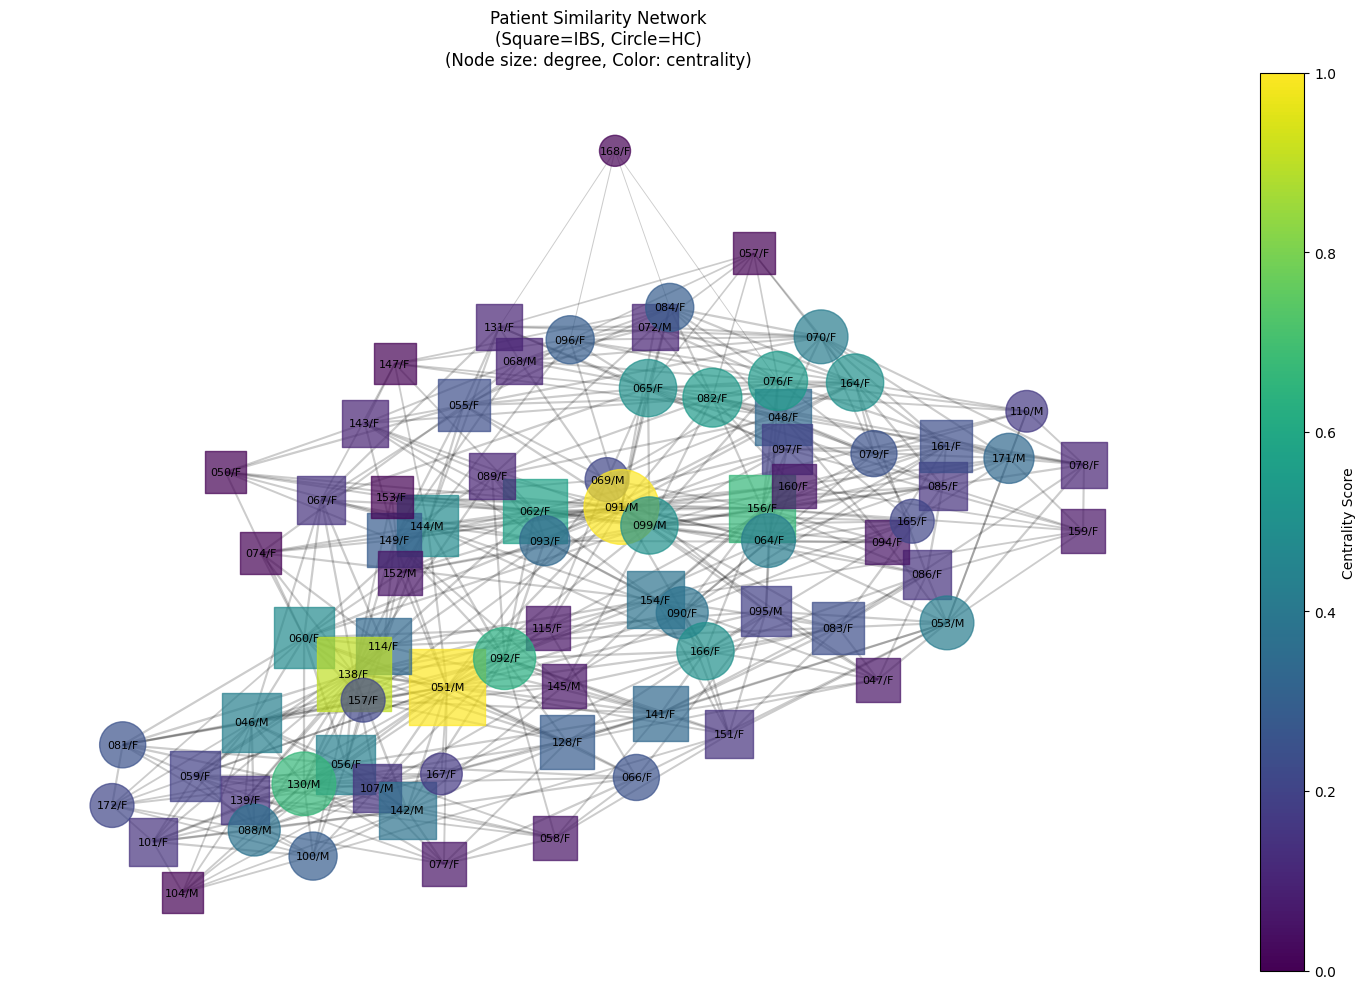

In [34]:
def create_and_analyze_network(threshold=0.3, k_nearest=8):
    """
    Create and analyze patient similarity network based on morphometric and cognitive variables only
    """
    
    # Step 1: Setup and load data
    DATA_PATH = setup_data_path()
    DATA_FILE = 'demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv'
    df = pd.read_csv(os.path.join(DATA_PATH, DATA_FILE))
    
    # Store subject info for later use in visualization
    subject_info = df[['Subject', 'Group', 'Gender']].copy()
    
    # Step 2: Preprocess data - select only morphometric and cognitive variables
    # Exclude demographic and clinical variables
    exclude_cols = ['Subject', 'Group', 'IBS_SSS', 'Age', 'Gender', 'Education']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Preprocess selected features
    scaled_data = StandardScaler().fit_transform(df[feature_cols])
    print(f"Features used: {len(feature_cols)}")

    # Step 3: Create network
    G, similarity_matrix = create_similarity_network(scaled_data, 
                                                   threshold=threshold, 
                                                   k_nearest=k_nearest)

    # Step 4: Analyze network
    metrics = analyze_network(G)
    
    # Step 5: Enhanced visualization with subject labels and group-based node shapes
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Calculate layout
    pos = nx.spring_layout(G, k=1/np.sqrt(G.number_of_nodes()), iterations=50)
    
    # Prepare node colors and sizes
    node_colors = list(metrics[0].values())
    degree_dict = dict(G.degree())
    node_sizes = [((v + 1) * 100) for v in degree_dict.values()]
    
    # Draw nodes based on group (IBS=square, HC=circle)
    ibs_nodes = [i for i, row in subject_info.iterrows() if row['Group'] == 'IBS']
    hc_nodes = [i for i, row in subject_info.iterrows() if row['Group'] == 'HC']
    
    # Draw IBS nodes (squares)
    nx.draw_networkx_nodes(G, pos, 
                          nodelist=ibs_nodes,
                          node_color=[node_colors[i] for i in ibs_nodes],
                          node_size=[node_sizes[i] for i in ibs_nodes],
                          node_shape='s',  # square
                          cmap=plt.cm.viridis,
                          alpha=0.7,
                          ax=ax)
    
    # Draw HC nodes (circles)
    nx.draw_networkx_nodes(G, pos, 
                          nodelist=hc_nodes,
                          node_color=[node_colors[i] for i in hc_nodes],
                          node_size=[node_sizes[i] for i in hc_nodes],
                          node_shape='o',  # circle
                          cmap=plt.cm.viridis,
                          alpha=0.7,
                          ax=ax)
    
    # Draw edges
    edge_weights = [G[u][v].get('weight', 0.1) for u,v in G.edges()]
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=[w*2 for w in edge_weights])
    
    # Add node labels (subject number and gender)
    labels = {i: f"{row['Subject'].split('_')[1]}/{row['Gender']}" 
             for i, row in subject_info.iterrows()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title('Patient Similarity Network\n(Square=IBS, Circle=HC)\n(Node size: degree, Color: centrality)')
    ax.set_axis_off()
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Centrality Score')
    
    plt.tight_layout()
    plt.show()
    
    return G, metrics, scaled_data, feature_cols

# Example usage:
if __name__ == "__main__":
    G, metrics, scaled_data, feature_cols = create_and_analyze_network()

_Display the graph for each community, separately._

Features used: 42

Network Analysis:
Number of nodes: 78
Number of edges: 495
Average degree: 12.69
Network density: 0.165
Average clustering coefficient: 0.420

Number of communities detected: 3


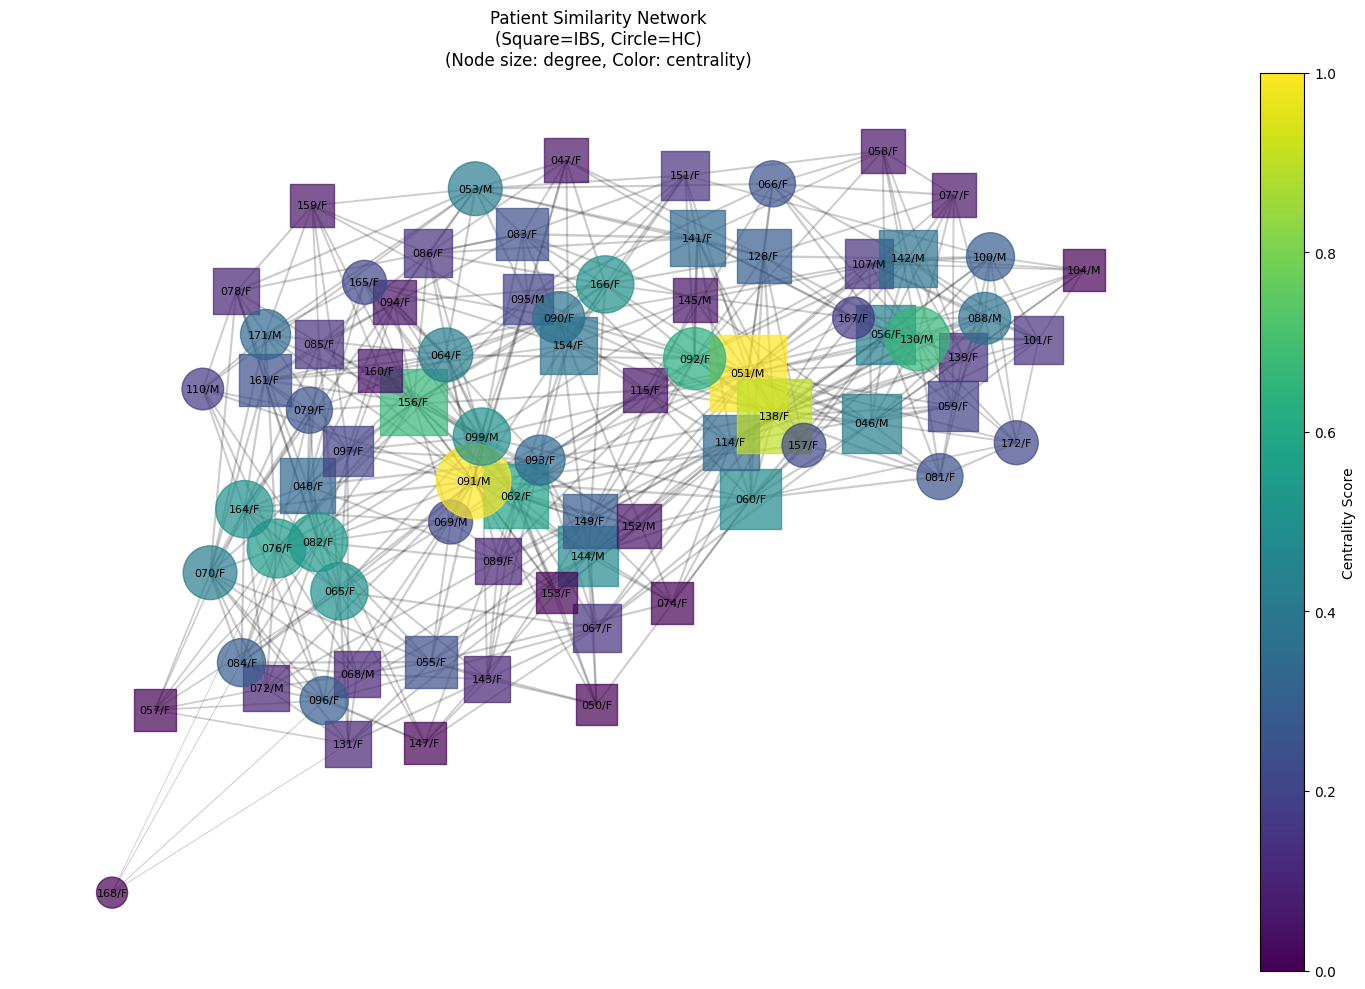

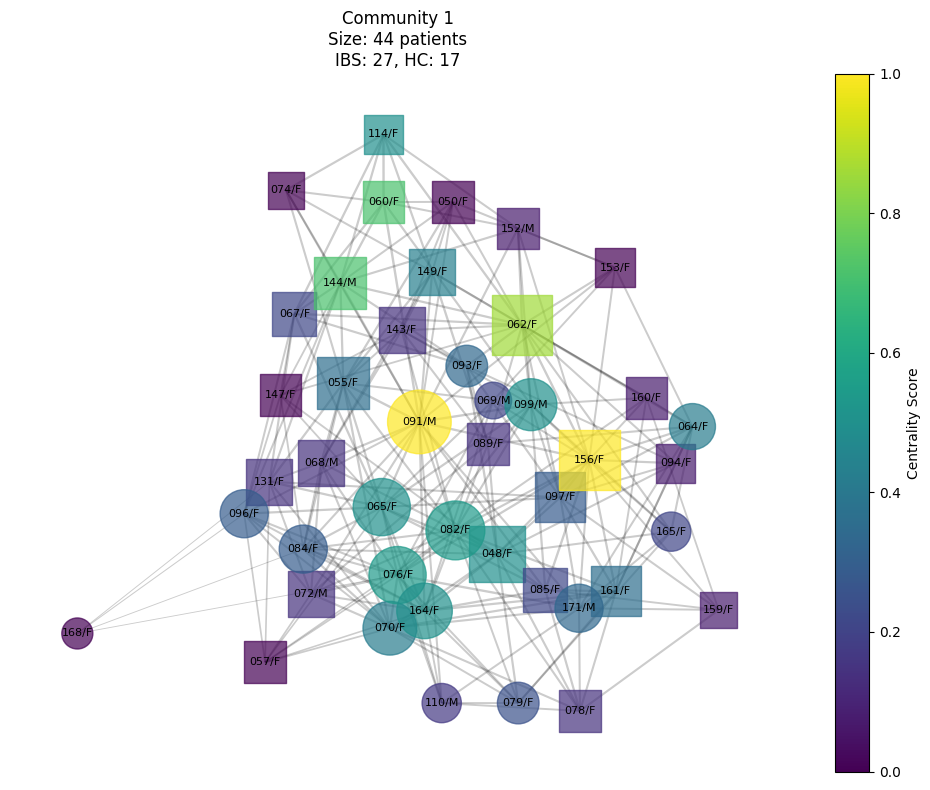


Community 1 Statistics:
Total patients: 44
IBS patients: 27 (61.4%)
HC patients: 17 (38.6%)
--------------------------------------------------


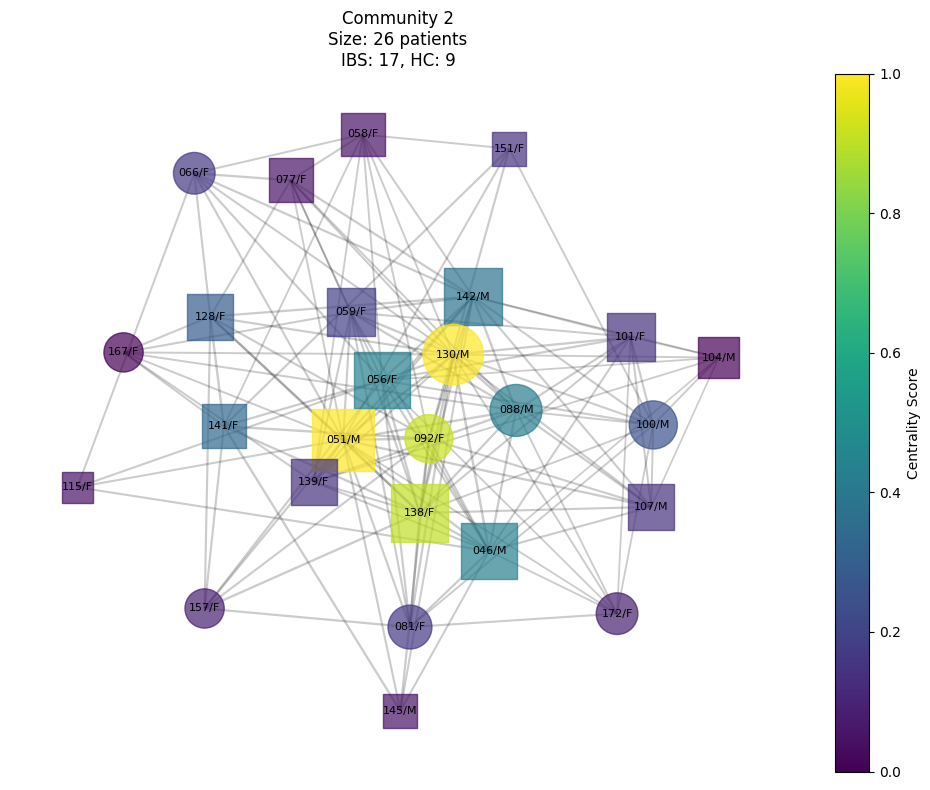


Community 2 Statistics:
Total patients: 26
IBS patients: 17 (65.4%)
HC patients: 9 (34.6%)
--------------------------------------------------


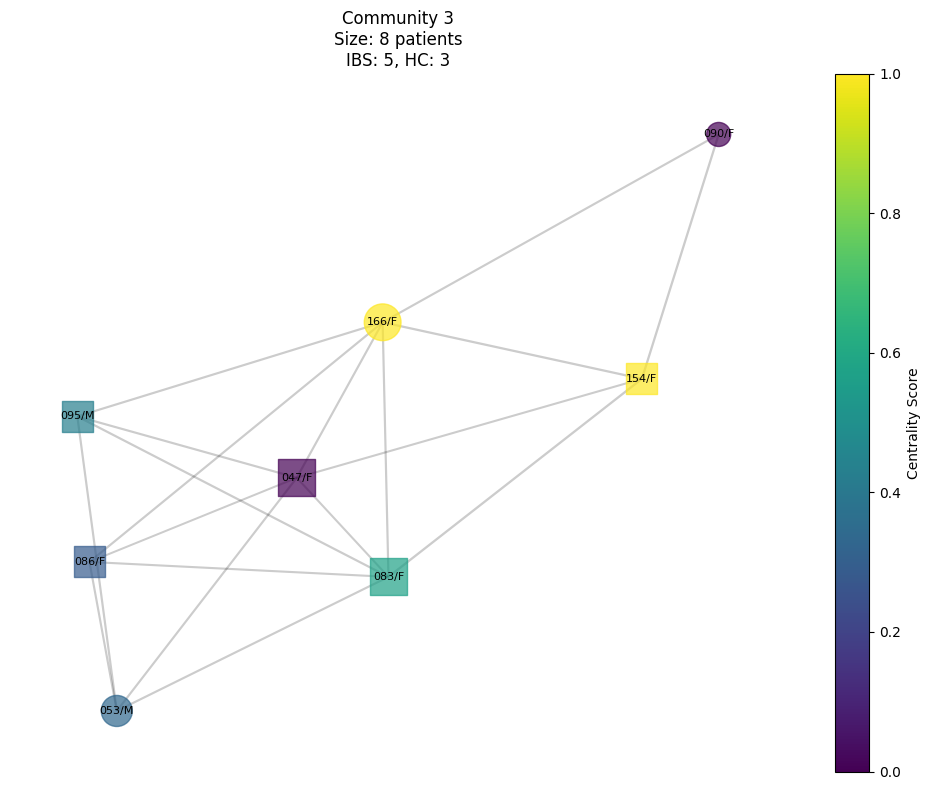


Community 3 Statistics:
Total patients: 8
IBS patients: 5 (62.5%)
HC patients: 3 (37.5%)
--------------------------------------------------


In [35]:
def visualize_communities(G, communities, subject_info, metrics):
    """
    Display separate graphs for each community in the network
    
    Parameters:
    -----------
    G : NetworkX graph
        The patient similarity network
    communities : list
        List of sets containing node indices for each community
    subject_info : DataFrame
        Contains Subject, Group, and Gender information
    metrics : tuple
        (degree_centrality, betweenness_centrality, communities)
    """
    
    # For each community
    for idx, community in enumerate(communities):
        # Create subgraph for this community
        subG = G.subgraph(community)
        
        # Create new figure for this community
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Calculate layout for this subgraph
        pos = nx.spring_layout(subG, k=1/np.sqrt(len(community)), iterations=50)
        
        # Prepare node colors and sizes for this community
        node_colors = [metrics[0][node] for node in subG.nodes()]
        node_sizes = [((subG.degree(node) + 1) * 100) for node in subG.nodes()]
        
        # Separate IBS and HC nodes
        ibs_nodes = [i for i in subG.nodes() if subject_info.iloc[i]['Group'] == 'IBS']
        hc_nodes = [i for i in subG.nodes() if subject_info.iloc[i]['Group'] == 'HC']
        
        # Draw IBS nodes (squares)
        if ibs_nodes:
            nx.draw_networkx_nodes(subG, pos,
                                 nodelist=ibs_nodes,
                                 node_color=[metrics[0][i] for i in ibs_nodes],
                                 node_size=[node_sizes[list(subG.nodes()).index(i)] for i in ibs_nodes],
                                 node_shape='s',
                                 cmap=plt.cm.viridis,
                                 alpha=0.7,
                                 ax=ax)
        
        # Draw HC nodes (circles)
        if hc_nodes:
            nx.draw_networkx_nodes(subG, pos,
                                 nodelist=hc_nodes,
                                 node_color=[metrics[0][i] for i in hc_nodes],
                                 node_size=[node_sizes[list(subG.nodes()).index(i)] for i in hc_nodes],
                                 node_shape='o',
                                 cmap=plt.cm.viridis,
                                 alpha=0.7,
                                 ax=ax)
        
        # Draw edges
        edge_weights = [subG[u][v].get('weight', 0.1) for u,v in subG.edges()]
        nx.draw_networkx_edges(subG, pos, alpha=0.2, width=[w*2 for w in edge_weights])
        
        # Add node labels
        labels = {i: f"{subject_info.iloc[i]['Subject'].split('_')[1]}/{subject_info.iloc[i]['Gender']}"
                 for i in subG.nodes()}
        nx.draw_networkx_labels(subG, pos, labels, font_size=8)
        
        # Add title and stats for this community
        plt.title(f'Community {idx+1}\n'
                 f'Size: {len(community)} patients\n'
                 f'IBS: {len(ibs_nodes)}, HC: {len(hc_nodes)}')
        ax.set_axis_off()
        
        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label='Centrality Score')
        
        plt.tight_layout()
        plt.show()
        
        # Print community statistics
        print(f"\nCommunity {idx+1} Statistics:")
        print(f"Total patients: {len(community)}")
        print(f"IBS patients: {len(ibs_nodes)} ({len(ibs_nodes)/len(community)*100:.1f}%)")
        print(f"HC patients: {len(hc_nodes)} ({len(hc_nodes)/len(community)*100:.1f}%)")
        print("-" * 50)

# Modify the main function to include community visualization
if __name__ == "__main__":
    G, (degree_cent, between_cent, communities), scaled_data, feature_cols = create_and_analyze_network()
    
    # Get subject info from original data
    DATA_PATH = setup_data_path()
    DATA_FILE = 'demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv'
    df = pd.read_csv(os.path.join(DATA_PATH, DATA_FILE))
    subject_info = df[['Subject', 'Group', 'Gender']]
    
    # Visualize each community
    visualize_communities(G, communities, subject_info, (degree_cent, between_cent, communities))

_Please add the statistics (or distribution or values) of the variables: Subject, Group, IBS_SSS, Age, Gender and Education for each of the generated communities._


Features used: 42

Network Analysis:
Number of nodes: 78
Number of edges: 495
Average degree: 12.69
Network density: 0.165
Average clustering coefficient: 0.420

Number of communities detected: 3


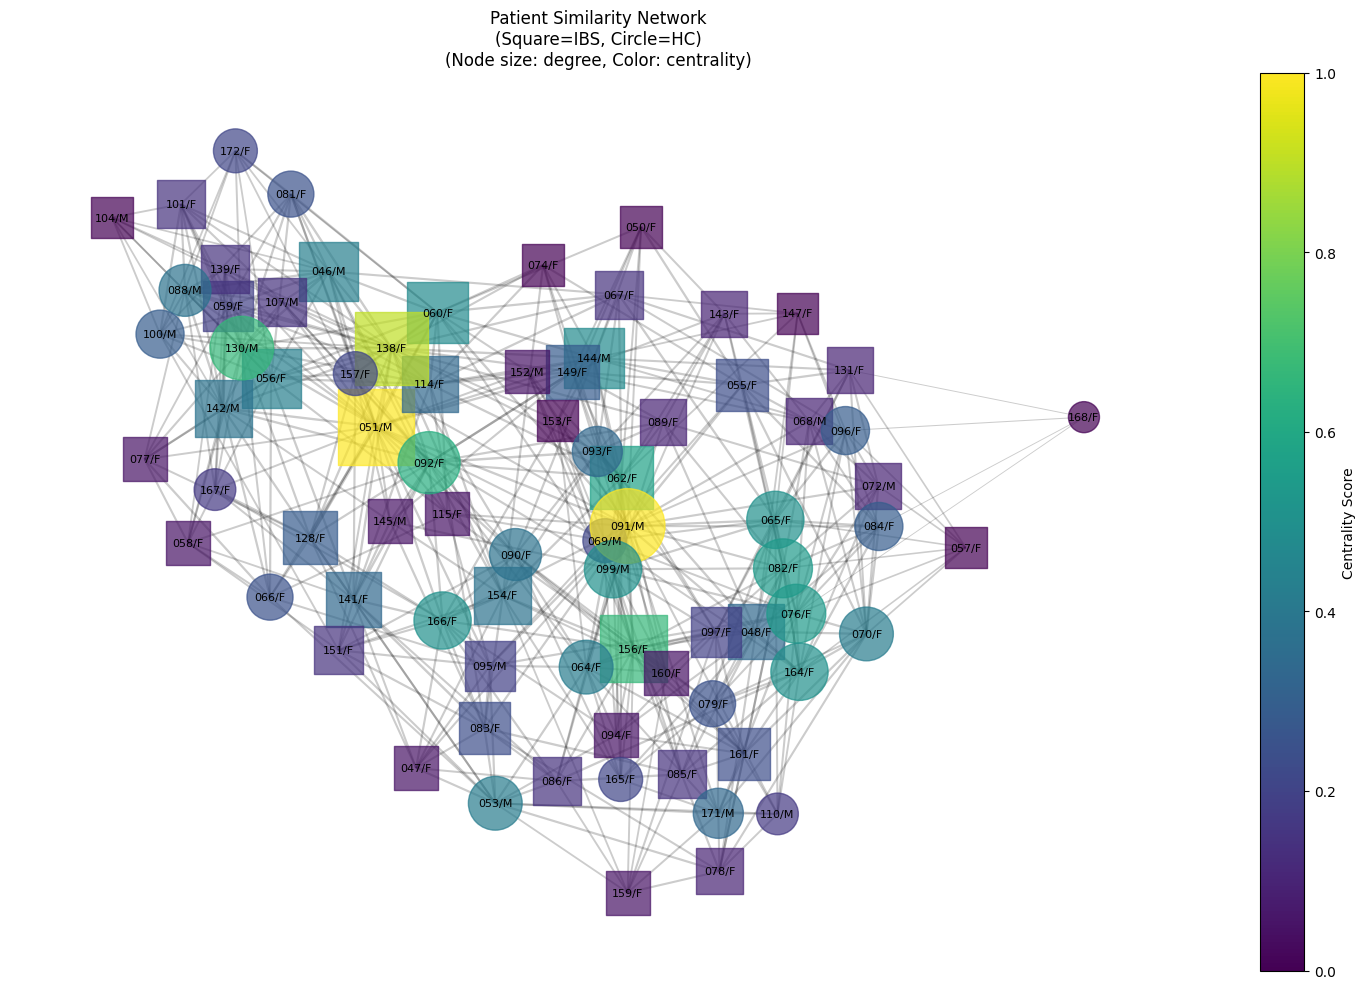


Community 1 Analysis


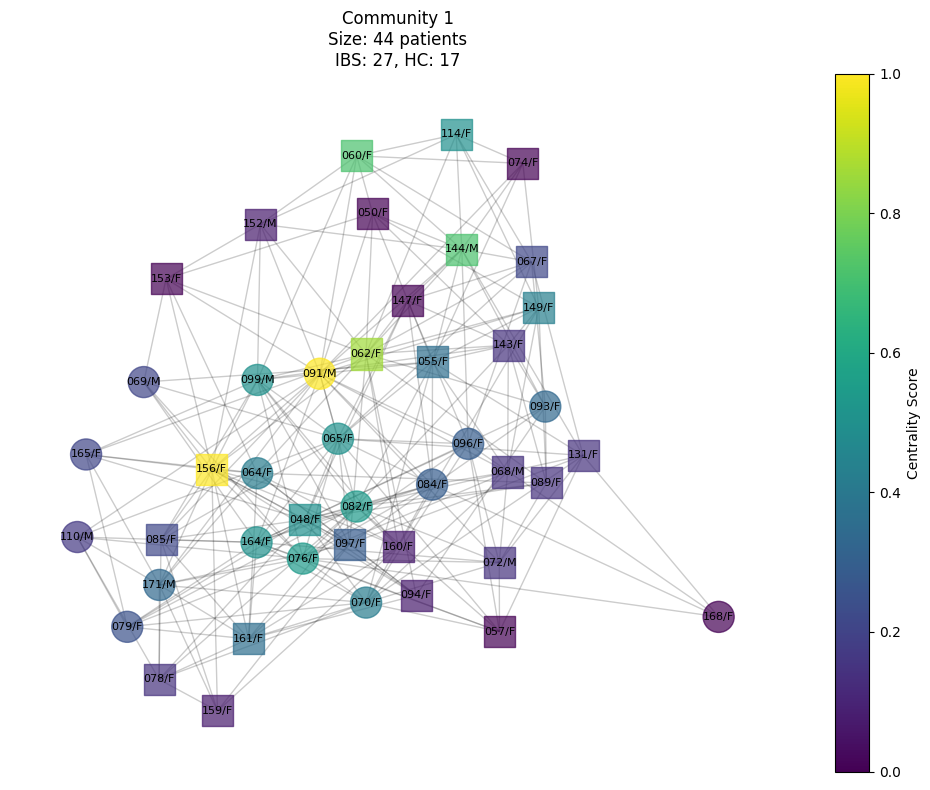


Detailed Community Statistics:
------------------------------

Group Distribution:
IBS: 27 (61.4%)
HC: 17 (38.6%)

Gender Distribution:
F: 35 (79.5%)
M: 9 (20.5%)

Numerical Variables Statistics:

Age:
Mean ± SD: 33.2 ± 10.4
Median [IQR]: 31.0 [23.8-41.2]
Range: 19.0-61.0

Education:
Mean ± SD: 16.4 ± 2.1
Median [IQR]: 16.0 [15.0-18.0]
Range: 13.0-21.0

IBS_SSS:
Mean ± SD: 178.7 ± 133.3
Median [IQR]: 201.0 [32.8-267.8]
Range: 0.0-418.0


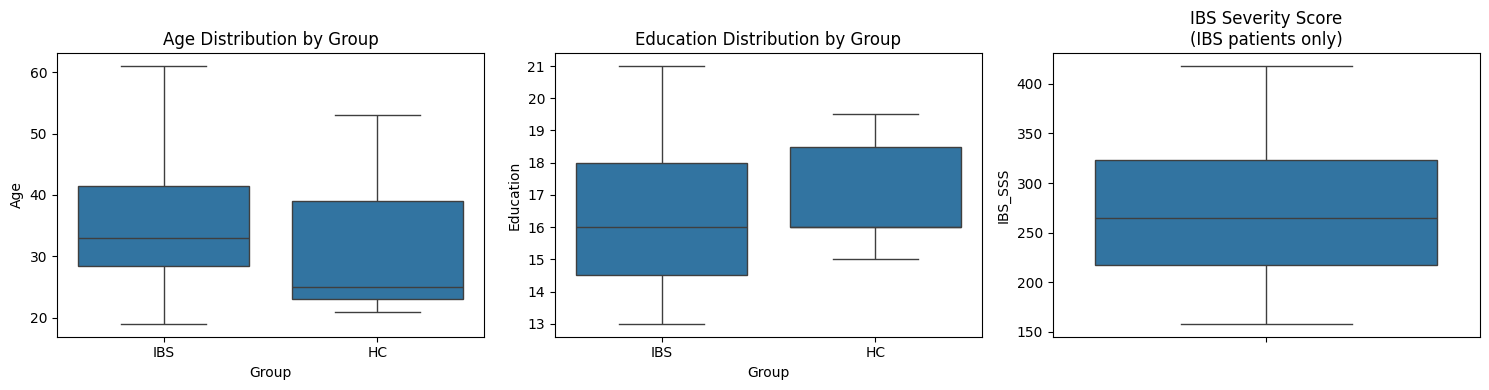


Community 2 Analysis


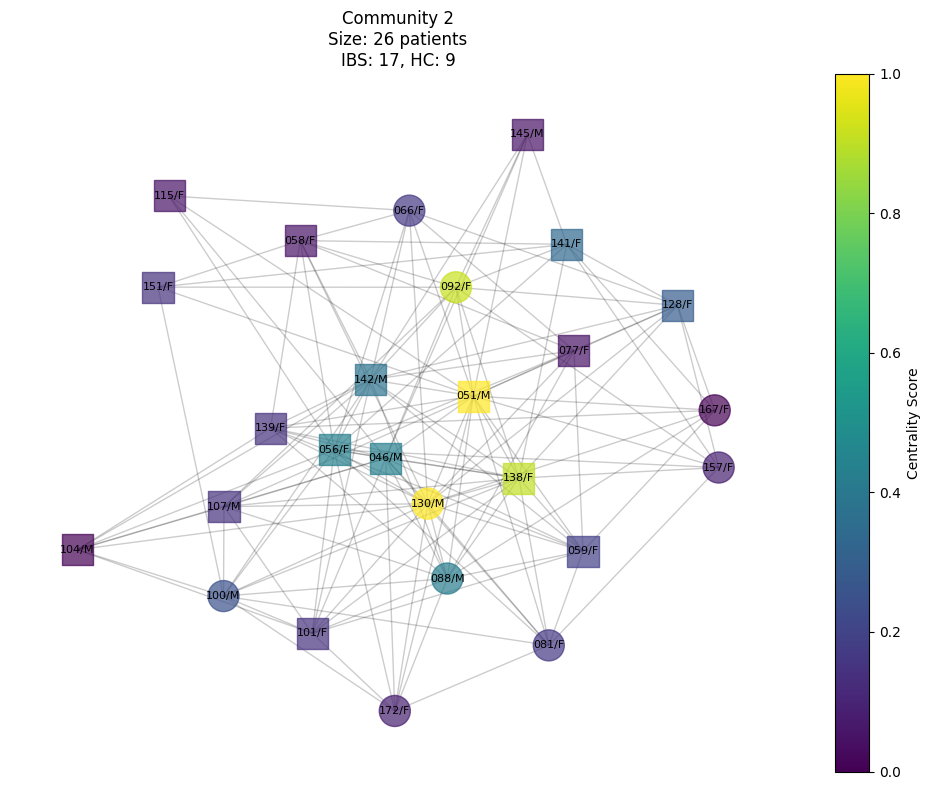


Detailed Community Statistics:
------------------------------

Group Distribution:
IBS: 17 (65.4%)
HC: 9 (34.6%)

Gender Distribution:
F: 17 (65.4%)
M: 9 (34.6%)

Numerical Variables Statistics:

Age:
Mean ± SD: 42.2 ± 10.7
Median [IQR]: 42.0 [34.2-51.2]
Range: 22.0-58.0

Education:
Mean ± SD: 15.7 ± 1.8
Median [IQR]: 15.5 [15.0-17.0]
Range: 12.0-18.0

IBS_SSS:
Mean ± SD: 182.8 ± 128.9
Median [IQR]: 231.5 [26.8-267.0]
Range: 0.0-413.0


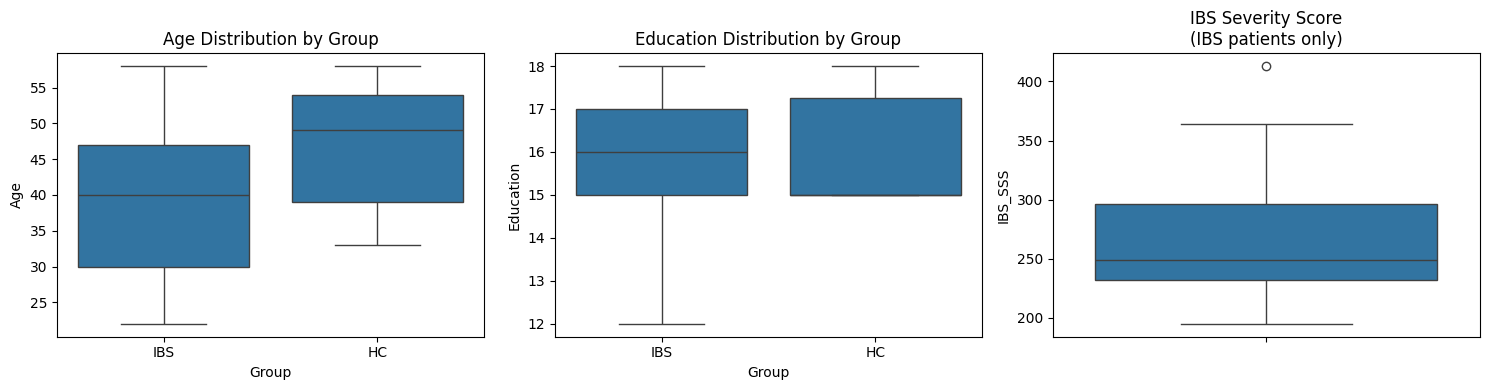


Community 3 Analysis


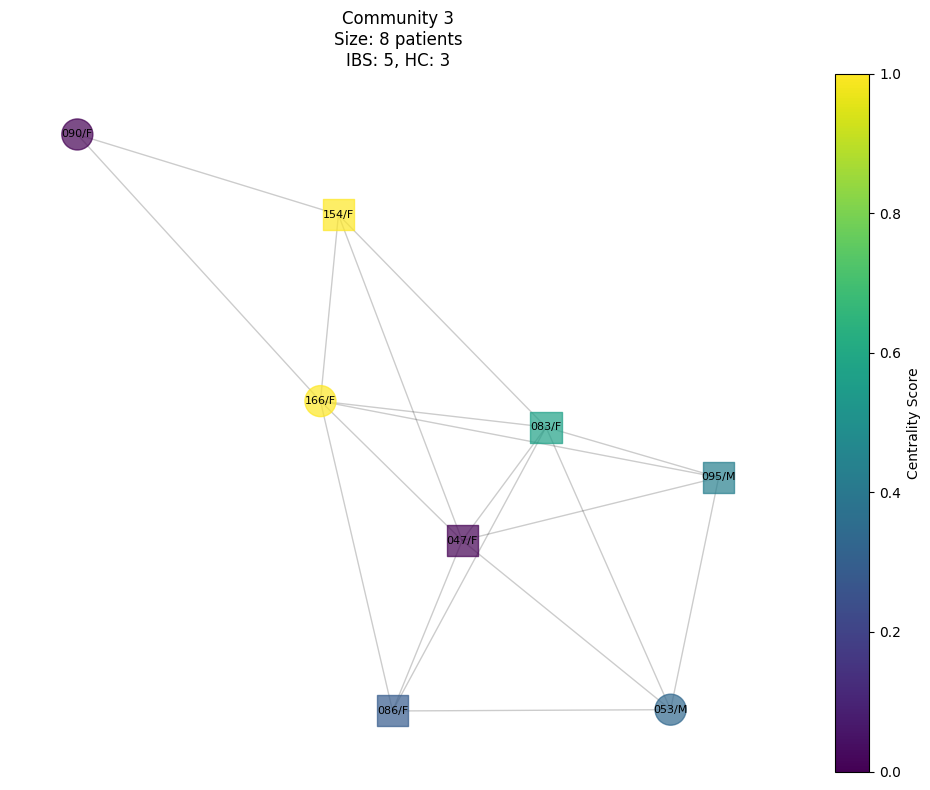


Detailed Community Statistics:
------------------------------

Group Distribution:
IBS: 5 (62.5%)
HC: 3 (37.5%)

Gender Distribution:
F: 6 (75.0%)
M: 2 (25.0%)

Numerical Variables Statistics:

Age:
Mean ± SD: 25.4 ± 6.1
Median [IQR]: 24.0 [21.2-28.5]
Range: 19.0-37.0

Education:
Mean ± SD: 15.2 ± 1.8
Median [IQR]: 15.0 [14.0-16.5]
Range: 13.0-17.5

IBS_SSS:
Mean ± SD: 206.6 ± 167.3
Median [IQR]: 223.5 [45.8-345.0]
Range: 0.0-405.0


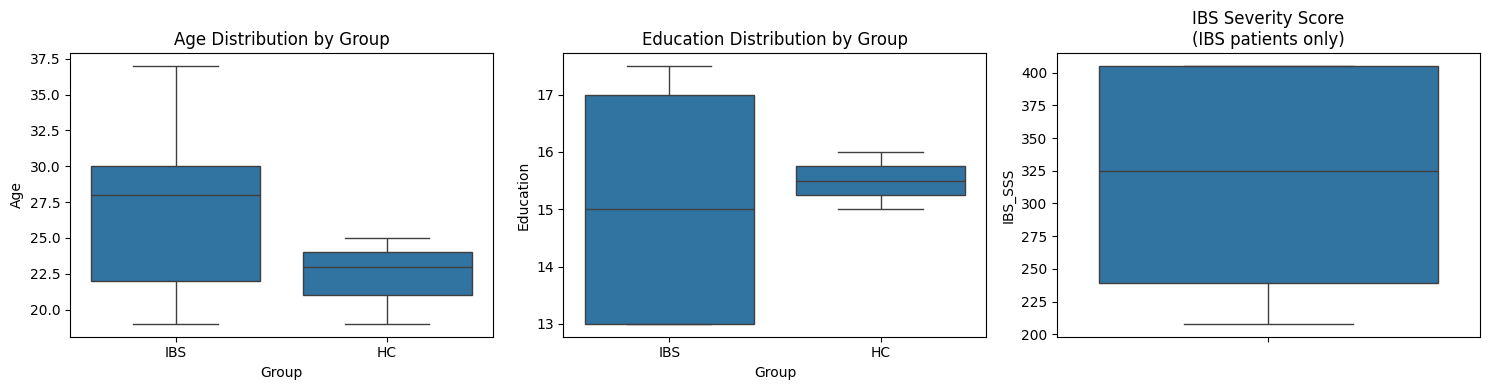

In [36]:
def analyze_community_demographics(community, df):
    """
    Analyze demographic and clinical variables for a community
    
    Parameters:
    -----------
    community : set
        Set of node indices for the community
    df : DataFrame
        Original dataframe with all patient information
    """
    # Get data for this community
    community_df = df.iloc[list(community)]
    
    print("\nDetailed Community Statistics:")
    print("-" * 30)
    
    # Group distribution
    group_dist = community_df['Group'].value_counts()
    print("\nGroup Distribution:")
    for group, count in group_dist.items():
        print(f"{group}: {count} ({count/len(community_df)*100:.1f}%)")
    
    # Gender distribution
    gender_dist = community_df['Gender'].value_counts()
    print("\nGender Distribution:")
    for gender, count in gender_dist.items():
        print(f"{gender}: {count} ({count/len(community_df)*100:.1f}%)")
    
    # Numerical variables statistics
    print("\nNumerical Variables Statistics:")
    for var in ['Age', 'Education', 'IBS_SSS']:
        data = community_df[var].dropna()
        if len(data) > 0:
            print(f"\n{var}:")
            print(f"Mean ± SD: {data.mean():.1f} ± {data.std():.1f}")
            print(f"Median [IQR]: {data.median():.1f} [{data.quantile(0.25):.1f}-{data.quantile(0.75):.1f}]")
            print(f"Range: {data.min():.1f}-{data.max():.1f}")
    
    # Optional: Create visualizations for numerical variables
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Age distribution
    sns.boxplot(data=community_df, y='Age', x='Group', ax=axes[0])
    axes[0].set_title('Age Distribution by Group')
    
    # Education distribution
    sns.boxplot(data=community_df, y='Education', x='Group', ax=axes[1])
    axes[1].set_title('Education Distribution by Group')
    
    # IBS_SSS distribution (only for IBS patients)
    ibs_data = community_df[community_df['Group'] == 'IBS']
    if len(ibs_data) > 0:
        sns.boxplot(data=ibs_data, y='IBS_SSS', ax=axes[2])
        axes[2].set_title('IBS Severity Score\n(IBS patients only)')
    
    plt.tight_layout()
    plt.show()


def visualize_communities(G, communities, subject_info, metrics, df):
    """
    Display separate graphs for each community with detailed demographics
    """
    for idx, community in enumerate(communities):
        print(f"\n{'='*50}")
        print(f"Community {idx+1} Analysis")
        print(f"{'='*50}")
        
        # Create subgraph for this community
        subG = G.subgraph(community)
        
        # Create figure for network visualization
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Calculate layout for this subgraph
        pos = nx.spring_layout(subG, k=1/np.sqrt(len(community)), iterations=50)
        
        # Separate IBS and HC nodes
        ibs_nodes = [i for i in community if df.iloc[i]['Group'] == 'IBS']
        hc_nodes = [i for i in community if df.iloc[i]['Group'] == 'HC']
        
        # Draw IBS nodes (squares)
        if ibs_nodes:
            nx.draw_networkx_nodes(subG, pos,
                                 nodelist=ibs_nodes,
                                 node_color=[metrics[0][i] for i in ibs_nodes],
                                 node_size=500,
                                 node_shape='s',
                                 cmap=plt.cm.viridis,
                                 alpha=0.7,
                                 ax=ax)
        
        # Draw HC nodes (circles)
        if hc_nodes:
            nx.draw_networkx_nodes(subG, pos,
                                 nodelist=hc_nodes,
                                 node_color=[metrics[0][i] for i in hc_nodes],
                                 node_size=500,
                                 node_shape='o',
                                 cmap=plt.cm.viridis,
                                 alpha=0.7,
                                 ax=ax)
        
        # Draw edges
        nx.draw_networkx_edges(subG, pos, 
                             alpha=0.2,
                             width=1,
                             ax=ax)
        
        # Add node labels
        labels = {i: f"{df.iloc[i]['Subject'].split('_')[1]}/{df.iloc[i]['Gender']}"
                 for i in community}
        nx.draw_networkx_labels(subG, pos, labels, font_size=8)
        
        plt.title(f'Community {idx+1}\n'
                 f'Size: {len(community)} patients\n'
                 f'IBS: {len(ibs_nodes)}, HC: {len(hc_nodes)}')
        ax.set_axis_off()
        
        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label='Centrality Score')
        
        plt.tight_layout()
        plt.show()
        
        # Add demographic analysis
        analyze_community_demographics(community, df)

# Modified main execution
if __name__ == "__main__":
    # Load full dataset
    DATA_PATH = setup_data_path()
    DATA_FILE = 'demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv'
    df = pd.read_csv(os.path.join(DATA_PATH, DATA_FILE))
    
    # Create and analyze network
    G, (degree_cent, between_cent, communities), scaled_data, feature_cols = create_and_analyze_network()
    
    # Visualize communities with demographic analysis
    visualize_communities(G, communities, df[['Subject', 'Group', 'Gender']], 
                         (degree_cent, between_cent, communities), df)

_Based on this PSN methodology, can you suggest a way to classify or characterize a new subject, say BGA_900, given the values for alle the variables in the data frame df?_

In [37]:
# Add required import
from scipy.spatial.distance import cdist

def characterize_new_subject(new_subject_data, df, G, communities, k_nearest=5):
    """
    Characterize a new subject based on existing PSN
    
    Parameters:
    -----------
    new_subject_data : pd.Series
        Data for new subject with same variables as df
    df : pd.DataFrame
        Original dataset used to create PSN
    G : networkx.Graph
        Existing patient similarity network
    communities : list
        List of communities from original network
    k_nearest : int
        Number of most similar patients to consider
    
    Returns:
    --------
    dict : Results of characterization
    """
    # Step 1: Preprocess new subject data
    # Use same feature selection and scaling as original network
    exclude_cols = ['Subject', 'Group', 'IBS_SSS', 'Age', 'Gender', 'Education']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Get original data for scaling
    X_orig = df[feature_cols].values
    
    # Combine new subject with original data for proper scaling
    new_data = new_subject_data[feature_cols].values.reshape(1, -1)
    X_combined = np.vstack([X_orig, new_data])
    
    # Scale all data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)
    
    # Extract scaled new subject data
    new_scaled = X_scaled[-1:]
    
    # Step 2: Calculate similarities to all existing patients
    distances = cdist(new_scaled, X_scaled[:-1], metric='euclidean')
    sigma = np.mean(distances) + 1e-8
    similarities = np.exp(-distances ** 2 / (2 * sigma ** 2))
    
    # Step 3: Find k most similar patients
    k_nearest_idx = np.argsort(similarities[0])[-k_nearest:]
    k_nearest_similarities = similarities[0][k_nearest_idx]
    
    # Step 4: Analyze community membership of similar patients
    community_votes = []
    for idx in k_nearest_idx:
        for comm_idx, comm in enumerate(communities):
            if idx in comm:
                community_votes.append(comm_idx)
                break
    
    # Get most common community
    from collections import Counter
    predicted_community = Counter(community_votes).most_common(1)[0][0]
    
    # Step 5: Analyze characteristics of similar patients
    similar_patients = df.iloc[k_nearest_idx]
    
    # Calculate predicted characteristics based on weighted average
    weighted_predictions = {}
    for col in ['Age', 'Education', 'IBS_SSS']:
        if col in similar_patients.columns:
            weights = k_nearest_similarities / np.sum(k_nearest_similarities)
            weighted_predictions[col] = np.average(
                similar_patients[col], weights=weights
            )
    
    # Predict group based on majority voting with similarity weights
    group_votes = similar_patients['Group'].value_counts()
    predicted_group = group_votes.index[0]
    group_confidence = group_votes.iloc[0] / len(k_nearest_idx)
    
    # Prepare results
    results = {
        'most_similar_patients': list(zip(
            similar_patients['Subject'], 
            k_nearest_similarities
        )),
        'predicted_community': predicted_community,
        'predicted_group': predicted_group,
        'group_confidence': group_confidence,
        'predicted_values': weighted_predictions,
        'community_distribution': Counter(community_votes)
    }
    
    # Print summary
    print(f"\nCharacterization of new subject:")
    print(f"Predicted community: {predicted_community}")
    print(f"Predicted group: {predicted_group} (confidence: {group_confidence:.2f})")
    print("\nMost similar patients:")
    for subject, sim in results['most_similar_patients']:
        print(f"  {subject}: similarity = {sim:.3f}")
    print("\nPredicted values:")
    for var, val in weighted_predictions.items():
        print(f"  {var}: {val:.2f}")
    
    return results

# Example usage:
if __name__ == "__main__":
    # Create a hypothetical new subject
    new_subject = df.iloc[0].copy()  # Copy an existing patient as example
    new_subject['Subject'] = 'BGA_900'  # Change ID
    
    # Characterize the new subject
    results = characterize_new_subject(
        new_subject, 
        df, 
        G, 
        communities
    )


Characterization of new subject:
Predicted community: 1
Predicted group: IBS (confidence: 0.80)

Most similar patients:
  BGA_138: similarity = 0.796
  BGA_051: similarity = 0.803
  BGA_059: similarity = 0.815
  BGA_130: similarity = 0.856
  BGA_046: similarity = 1.000

Predicted values:
  Age: 39.51
  Education: 15.23
  IBS_SSS: 216.13


This approach:

1. **Preprocesses** the new subject's data using the same method as the original network

2. **Finds Similar Patients** by:
   - Calculating similarities to all existing patients
   - Identifying k most similar patients
   - Analyzing their characteristics

3. **Makes Predictions** about:
   - Community membership (which subgroup)
   - Patient group (IBS vs HC)
   - Clinical/demographic values (weighted by similarity)

4. **Provides Confidence Measures** through:
   - Similarity scores
   - Voting distributions
   - Weighted predictions

5. **Returns Detailed Results** including:
   - Most similar existing patients
   - Predicted characteristics
   - Confidence measures
   - Community assignment

This method allows you to:
- Place new patients in the existing network structure
- Predict their likely characteristics
- Understand their relationship to existing patient groups
- Get confidence measures for predictions

The predictions are based on the characteristics of similar existing patients, weighted by their similarity to the new patient.


_Based on this approach, can you suggest a leave-one-out validation technique for predicting new cases based on PSN methodology?_



Validating patient 1/78

Network Analysis:
Number of nodes: 77
Number of edges: 489
Average degree: 12.70
Network density: 0.167
Average clustering coefficient: 0.417

Number of communities detected: 3

Characterization of new subject:
Predicted community: 0
Predicted group: IBS (confidence: 0.60)

Most similar patients:
  BGA_088: similarity = 0.796
  BGA_138: similarity = 0.800
  BGA_051: similarity = 0.808
  BGA_059: similarity = 0.820
  BGA_130: similarity = 0.860

Predicted values:
  Age: 38.62
  Education: 16.57
  IBS_SSS: 180.99

Validating patient 2/78

Network Analysis:
Number of nodes: 77
Number of edges: 487
Average degree: 12.65
Network density: 0.166
Average clustering coefficient: 0.418

Number of communities detected: 3

Characterization of new subject:
Predicted community: 2
Predicted group: IBS (confidence: 0.60)

Most similar patients:
  BGA_083: similarity = 0.758
  BGA_154: similarity = 0.765
  BGA_053: similarity = 0.788
  BGA_166: similarity = 0.794
  BGA_095: si

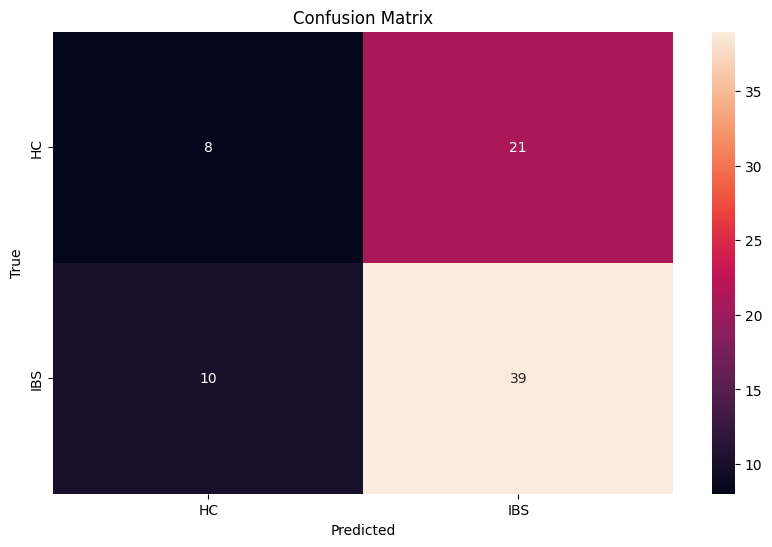

In [38]:
def leave_one_out_validation(df, threshold=0.3, k_nearest=8, k_similar=5):
    """
    Perform leave-one-out validation using PSN methodology
    
    Parameters:
    -----------
    df : DataFrame
        Original dataset
    threshold : float
        Similarity threshold for network creation
    k_nearest : int
        Number of neighbors for network creation
    k_similar : int
        Number of similar patients for prediction
        
    Returns:
    --------
    dict : Validation results
    """
    from sklearn.metrics import accuracy_score, confusion_matrix
    
    # Store predictions and actual values
    predictions = []
    true_values = []
    community_predictions = []
    similarities_list = []
    
    # For each patient in the dataset
    for i in range(len(df)):
        print(f"\nValidating patient {i+1}/{len(df)}")
        
        # Step 1: Split data into test (current patient) and training (rest)
        test_patient = df.iloc[i]
        train_df = df.drop(index=df.index[i])
        
        # Step 2: Create network without current patient
        # Preprocess training data
        exclude_cols = ['Subject', 'Group', 'IBS_SSS', 'Age', 'Gender', 'Education']
        feature_cols = [col for col in train_df.columns if col not in exclude_cols]
        scaled_data = StandardScaler().fit_transform(train_df[feature_cols])
        
        # Create network
        G, _ = create_similarity_network(scaled_data, threshold=threshold, k_nearest=k_nearest)
        
        # Analyze network
        _, _, communities = analyze_network(G)
        
        # Step 3: Predict current patient
        results = characterize_new_subject(
            test_patient,
            train_df,
            G,
            communities,
            k_nearest=k_similar
        )
        
        # Store results
        predictions.append(results['predicted_group'])
        true_values.append(test_patient['Group'])
        community_predictions.append(results['predicted_community'])
        similarities_list.append(results['most_similar_patients'])
    
    # Calculate performance metrics
    accuracy = accuracy_score(true_values, predictions)
    conf_matrix = confusion_matrix(true_values, predictions)
    
    # Analyze community stability
    community_analysis = pd.DataFrame({
        'True_Group': true_values,
        'Predicted_Group': predictions,
        'Predicted_Community': community_predictions
    })
    
    # Calculate average similarity scores
    avg_similarities = np.mean([
        [sim for _, sim in patient_sims] 
        for patient_sims in similarities_list
    ])
    
    # Print results
    print("\nValidation Results:")
    print(f"Overall Accuracy: {accuracy:.3f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print(f"\nAverage Similarity Score: {avg_similarities:.3f}")
    
    # Analyze predictions by group
    group_accuracy = pd.DataFrame({
        'True': true_values,
        'Predicted': predictions
    }).groupby('True').apply(
        lambda x: accuracy_score(x['True'], x['Predicted'])
    )
    print("\nAccuracy by Group:")
    print(group_accuracy)
    
    # Optional: Analyze misclassifications
    misclassified = pd.DataFrame({
        'Subject': df['Subject'],
        'True_Group': true_values,
        'Predicted_Group': predictions,
        'Community': community_predictions
    })
    misclassified['Correct'] = misclassified['True_Group'] == misclassified['Predicted_Group']
    
    # Return detailed results
    return {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'predictions': misclassified,
        'avg_similarities': avg_similarities,
        'group_accuracy': group_accuracy,
        'community_analysis': community_analysis
    }

# Example usage:
if __name__ == "__main__":
    # Run leave-one-out validation
    validation_results = leave_one_out_validation(
        df,
        threshold=0.3,
        k_nearest=8,
        k_similar=5
    )
    
    # Additional analysis of results
    print("\nDetailed Analysis of Misclassifications:")
    misclassified_cases = validation_results['predictions'][
        ~validation_results['predictions']['Correct']
    ]
    print(misclassified_cases)
    
    # Visualize results
    plt.figure(figsize=(10, 6))
    sns.heatmap(validation_results['confusion_matrix'], 
                annot=True, 
                fmt='d',
                xticklabels=['HC', 'IBS'],
                yticklabels=['HC', 'IBS'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

This validation approach:

1. **For Each Patient:**
   - Removes them from the dataset
   - Creates network without them
   - Predicts their characteristics using remaining patients
   - Compares predictions to actual values

2. **Calculates Performance Metrics:**
   - Overall accuracy
   - Group-specific accuracy
   - Confusion matrix
   - Average similarity scores

3. **Analyzes Predictions:**
   - Community stability
   - Misclassification patterns
   - Similarity distributions

4. **Provides Insights About:**
   - Model reliability
   - Group-specific performance
   - Network stability
   - Prediction confidence

This helps:
- Validate the PSN methodology
- Identify potential biases
- Understand prediction reliability
- Find areas for improvement

The results can guide:
- Parameter tuning (threshold, k_nearest)
- Feature selection
- Methodology improvements
- Clinical applications


_Please explain Step 3 (Network Creation),  Step 4 (Network Analysis) and community detection mathematically - use LaTeX_

Here's the mathematical explanation of the network creation, analysis, and community detection steps:

**Step 3: Network Creation**

1. **Distance Calculation**:
For patients $i$ and $j$ with feature vectors $x_i, x_j \in \mathbb{R}^d$, the Euclidean distance is:
$$
d_{ij} = \|x_i - x_j\| = \sqrt{\sum_{k=1}^d (x_{ik} - x_{jk})^2}
$$

2. **Similarity Transformation**:
Convert distances to similarities using Gaussian kernel:
$$
s_{ij} = \exp\left(-\frac{d_{ij}^2}{2\sigma^2}\right)
$$
where $\sigma$ is the mean distance: $\sigma = \frac{1}{n(n-1)}\sum_{i,j} d_{ij}$

3. **Network Construction**:
For each patient $i$:
- Find $k$ nearest neighbors: $\mathcal{N}_k(i) = \{j : s_{ij} \text{ is among } k \text{ largest similarities}\}$
- Add edge $(i,j)$ if:
$$
j \in \mathcal{N}_k(i) \text{ and } s_{ij} > \text{threshold}
$$

**Step 4: Network Analysis**

1. **Basic Metrics**:
- Network density: $\delta = \frac{2|E|}{|V|(|V|-1)}$
- Average degree: $\bar{k} = \frac{2|E|}{|V|}$
- Clustering coefficient for node $i$:
$$
C_i = \frac{2|\{(j,k) \in E : j,k \in \mathcal{N}(i)\}|}{k_i(k_i-1)}
$$
where $k_i$ is degree of node $i$

2. **Centrality Measures**:
- Degree centrality:
$$
C_D(i) = \frac{k_i}{|V|-1}
$$
- Betweenness centrality:
$$
C_B(i) = \sum_{s \neq i \neq t} \frac{\sigma_{st}(i)}{\sigma_{st}}
$$
where $\sigma_{st}$ is number of shortest paths between $s,t$, and $\sigma_{st}(i)$ is number passing through $i$

**Community Detection**

Using Louvain method for modularity optimization:

1. **Modularity Function**:
$$
Q = \frac{1}{2m}\sum_{ij} \left[A_{ij} - \frac{k_i k_j}{2m}\right]\delta(c_i,c_j)
$$
where:
- $A_{ij}$ is adjacency matrix
- $k_i, k_j$ are node degrees
- $m$ is total edge weight
- $c_i, c_j$ are community labels
- $\delta(c_i,c_j)$ is Kronecker delta

2. **Optimization Process**:
- Phase 1: Iteratively move nodes to maximize local modularity gain
$$
\Delta Q = \left[\frac{\Sigma_{in} + k_{i,in}}{2m} - \left(\frac{\Sigma_{tot} + k_i}{2m}\right)^2\right] - \left[\frac{\Sigma_{in}}{2m} - \left(\frac{\Sigma_{tot}}{2m}\right)^2 - \left(\frac{k_i}{2m}\right)^2\right]
$$
where:
- $\Sigma_{in}$ is sum of weights inside community
- $\Sigma_{tot}$ is sum of weights of links incident to nodes in community
- $k_{i,in}$ is sum of weights of links from $i$ to nodes in community
- $k_i$ is sum of weights of links incident to node $i$

- Phase 2: Aggregate nodes in same community and repeat

The algorithm iterates these phases until no improvement in modularity is possible.

This mathematical framework:
1. Creates meaningful patient similarities
2. Builds network structure
3. Identifies important patients
4. Discovers natural patient groupings

The parameters (threshold, k_nearest) control network sparsity and community granularity.


_Suggest five student projects for further exploration and improvements of this PSN approach using the present data defined by the pandas dataframe df._

Here are five suggested student projects for exploring and improving the PSN approach:

1. **Feature Selection and Weighting Project**
```python
"""
Project Goal: Optimize feature importance in PSN construction

Key Steps:
1. Feature importance analysis:
   - Use random forests to rank features
   - Calculate correlation matrices
   - Implement PCA/factor analysis

2. Weighted similarity measures:
   - Modify distance calculation:
   d_ij = sqrt(sum(w_k * (x_ik - x_jk)^2))
   where w_k are feature weights

3. Compare network structures:
   - Original vs weighted features
   - Different feature subsets
   - Impact on community detection

4. Validation metrics:
   - Community stability
   - Classification accuracy
   - Clinical relevance of groupings
"""

def weighted_similarity_network(df, feature_weights):
    # Implementation here
    pass
```

2. **Dynamic PSN Analysis Project**
```python
"""
Project Goal: Analyze network stability and robustness

Key Steps:
1. Bootstrap analysis:
   - Random subsampling of patients
   - Perturbation of feature values
   - Multiple network constructions

2. Stability metrics:
   - Community persistence
   - Node role consistency
   - Edge reliability

3. Parameter sensitivity:
   - Impact of threshold values
   - Effect of k_nearest changes
   - Similarity measure variations

4. Visualization:
   - Confidence intervals for edges
   - Node role probability
   - Community overlap diagrams
"""

def network_stability_analysis(df, n_iterations=100):
    # Implementation here
    pass
```

3. **Clinical Subtype Discovery Project**
```python
"""
Project Goal: Identify and validate clinical subtypes

Key Steps:
1. Enhanced community detection:
   - Multiple algorithms comparison
   - Hierarchical community structure
   - Overlapping communities

2. Clinical characterization:
   - Detailed demographic analysis
   - Symptom pattern analysis
   - Outcome correlations

3. Validation:
   - External clinical criteria
   - Literature comparison
   - Expert clinician review

4. Subtype prediction:
   - New patient classification
   - Confidence measures
   - Clinical interpretation
"""

def clinical_subtype_analysis(df, communities):
    # Implementation here
    pass
```

4. **Multi-Layer PSN Project**
```python
"""
Project Goal: Create and analyze multi-layer patient networks

Key Steps:
1. Layer definition:
   - Morphometric features
   - Cognitive measures
   - Clinical symptoms
   - Demographics

2. Layer integration:
   - Inter-layer edges
   - Layer weights
   - Aggregate measures

3. Multi-layer analysis:
   - Layer-specific communities
   - Cross-layer patterns
   - Node role across layers

4. Clinical applications:
   - Multi-aspect patient similarity
   - Comprehensive subtyping
   - Layer importance for outcomes
"""

def multilayer_network_analysis(df):
    # Implementation here
    pass
```

5. **Predictive PSN Project**
```python
"""
Project Goal: Develop predictive models using PSN structure

Key Steps:
1. Network-based features:
   - Node embeddings
   - Community memberships
   - Centrality measures
   - Path-based features

2. Prediction tasks:
   - IBS severity
   - Treatment response
   - Symptom progression
   - Comorbidity risk

3. Model development:
   - Graph neural networks
   - Network-aware classifiers
   - Ensemble methods
   - Uncertainty estimation

4. Clinical validation:
   - Prediction accuracy
   - Feature importance
   - Clinical interpretability
   - Practical utility
"""

def network_based_prediction(df, G, target_variable):
    # Implementation here
    pass
```

Each project:
- Has clear objectives
- Builds on existing code
- Addresses important clinical questions
- Combines theory and practice
- Produces actionable results

The projects can be scaled based on:
- Student level (undergraduate/graduate)
- Time available (semester/year)
- Technical expertise
- Clinical focus

Required skills include:
- Python programming
- Network analysis
- Statistical methods
- Clinical knowledge
- Data visualization


_Rank each of the five projects according to diffuculty - conceptially and technically._

Here's a ranking of the five projects by difficulty (1=least difficult, 5=most difficult):

**Conceptual Difficulty Ranking:**

1. **Feature Selection and Weighting Project**
   - Familiar statistical concepts
   - Clear objective (feature importance)
   - Well-established methods
   - Straightforward validation
   - Direct interpretation

2. **Dynamic PSN Analysis Project**
   - Bootstrap concepts are intuitive
   - Clear stability metrics
   - Visual interpretation
   - Standard statistical tests
   - Familiar validation methods

3. **Clinical Subtype Discovery Project**
   - Requires clinical knowledge
   - Community detection concepts
   - Validation complexity
   - Multiple algorithm comparison
   - Clinical interpretation needed

4. **Predictive PSN Project**
   - Complex prediction tasks
   - Model selection challenges
   - Uncertainty quantification
   - Clinical validation complexity
   - Feature engineering concepts

5. **Multi-Layer PSN Project**
   - Abstract network concepts
   - Layer integration complexity
   - Multi-dimensional thinking
   - Complex interpretation
   - Advanced network theory

**Technical Difficulty Ranking:**

1. **Dynamic PSN Analysis Project**
   - Standard Python libraries
   - Basic network metrics
   - Simple visualizations
   - Straightforward iterations
   - Basic statistical tests

2. **Feature Selection and Weighting Project**
   - Standard ML libraries
   - Matrix operations
   - Basic optimization
   - Common visualization tools
   - Standard validation methods

3. **Clinical Subtype Discovery Project**
   - Multiple algorithms
   - Community detection implementation
   - Statistical validation
   - Advanced visualization
   - Data integration

4. **Multi-Layer PSN Project**
   - Complex data structures
   - Custom network metrics
   - Layer integration code
   - Advanced visualization
   - Performance optimization

5. **Predictive PSN Project**
   - Graph neural networks
   - Advanced ML frameworks
   - Custom loss functions
   - Complex model architectures
   - Performance optimization

**Combined Considerations:**
1. **Time Requirements:**
   - Feature Selection: 1-2 months
   - Dynamic Analysis: 2-3 months
   - Clinical Subtypes: 3-4 months
   - Multi-Layer PSN: 4-6 months
   - Predictive PSN: 4-6 months

2. **Required Background:**
   - Feature Selection: Basic statistics, ML
   - Dynamic Analysis: Basic networks, statistics
   - Clinical Subtypes: Networks, clinical knowledge
   - Multi-Layer PSN: Advanced networks, math
   - Predictive PSN: Deep learning, advanced ML

3. **Resource Needs:**
   - Feature Selection: Standard computing
   - Dynamic Analysis: Standard computing
   - Clinical Subtypes: Standard computing, clinical data
   - Multi-Layer PSN: High memory, possibly GPU
   - Predictive PSN: GPU computing, large datasets

4. **Recommended For:**
   - Feature Selection: Advanced undergrad
   - Dynamic Analysis: Advanced undergrad
   - Clinical Subtypes: Early graduate
   - Multi-Layer PSN: Advanced graduate
   - Predictive PSN: Advanced graduate

This ranking helps in:
- Project assignment based on student level
- Resource allocation
- Timeline planning
- Support requirements
- Expected outcomes


_It seems that all the suggested projects are too difficult for the medical students in the course or too time consuming. Most students have little experience in Python programming or in mathematics, and they only have 2 weeks to complete the project, working in groups of 4 students. Could you suggest five simpler projects related to our PSN methodology being suitable regarding modest technical skills and short time frame?_




Here are five simpler projects suitable for medical students with basic programming skills and a 2-week timeframe:

1. **Clinical Interpretation of Communities Project**
````python
"""
Project Goal: Analyze and interpret patient communities from clinical perspective

Key Steps:
1. For each community:
   - Summarize basic demographics (age, gender)
   - Compare IBS severity scores
   - Analyze education levels
   - Count IBS vs HC ratios

2. Create simple visualizations:
   - Bar charts of key variables
   - Box plots comparing groups
   - Pie charts of distributions

3. Clinical interpretation:
   - Describe patient profiles in each community
   - Identify distinguishing characteristics
   - Suggest clinical relevance

Time: 2 weeks
Group size: 4 students
Skills needed: Basic Python (pandas, matplotlib)
"""

# Example starter code
def analyze_community_characteristics(df, communities):
    for i, community in enumerate(communities):
        community_df = df.iloc[list(community)]
        
        print(f"\nCommunity {i+1} Analysis:")
        print("------------------------")
        print(f"Size: {len(community)} patients")
        print(f"IBS patients: {sum(community_df['Group']=='IBS')}")
        print(f"HC patients: {sum(community_df['Group']=='HC')}")
        print(f"Average age: {community_df['Age'].mean():.1f}")
        # Add more analysis as needed
````

2. **Network Visualization Enhancement Project**
````python
"""
Project Goal: Create clinically meaningful visualizations of the PSN

Key Steps:
1. Color coding by different variables:
   - IBS severity
   - Age groups
   - Gender
   - Education levels

2. Node labeling improvements:
   - Add clinical annotations
   - Highlight key patients
   - Mark community boundaries

3. Create interactive plots:
   - Hover information
   - Zoom capabilities
   - Filtering options

Time: 2 weeks
Group size: 4 students
Skills needed: Basic Python (networkx, plotly)
"""

# Example starter code
def visualize_network_by_variable(G, df, color_variable):
    plt.figure(figsize=(12, 8))
    # Add visualization code
    # Color nodes by selected variable
    # Add labels and legend
````

3. **Patient Similarity Analysis Project**
````python
"""
Project Goal: Investigate what makes patients similar or different

Key Steps:
1. Select patient pairs:
   - Most similar pairs
   - Most different pairs
   - Same/different groups

2. Compare characteristics:
   - Create comparison tables
   - Calculate key differences
   - Visualize patterns

3. Clinical relevance:
   - Identify key distinguishing features
   - Suggest clinical implications
   - Document findings

Time: 2 weeks
Group size: 4 students
Skills needed: Basic Python (pandas, basic statistics)
"""

# Example starter code
def compare_patient_pairs(df, similarity_matrix):
    # Find most/least similar pairs
    # Create comparison tables
    # Generate simple visualizations
````

4. **Demographic Impact Project**
````python
"""
Project Goal: Study how demographics affect network structure

Key Steps:
1. Basic analysis:
   - Age distribution in communities
   - Gender patterns
   - Education level effects

2. Simple visualizations:
   - Age histograms by community
   - Gender proportion charts
   - Education level comparisons

3. Write clinical summary:
   - Key demographic patterns
   - Community characteristics
   - Clinical implications

Time: 2 weeks
Group size: 4 students
Skills needed: Basic Python (pandas, basic plotting)
"""

# Example starter code
def analyze_demographics(df, communities):
    # Create demographic summaries
    # Generate simple plots
    # Calculate basic statistics
````

5. **IBS Severity Pattern Project**
````python
"""
Project Goal: Analyze IBS severity patterns in the network

Key Steps:
1. Basic analysis:
   - IBS_SSS distribution
   - Severity by community
   - Relationship with other variables

2. Simple visualizations:
   - Severity histograms
   - Box plots by community
   - Basic correlation plots

3. Clinical interpretation:
   - Severity patterns
   - Community characteristics
   - Treatment implications

Time: 2 weeks
Group size: 4 students
Skills needed: Basic Python (pandas, basic statistics)
"""

# Example starter code
def analyze_ibs_patterns(df, communities):
    # Analyze IBS severity scores
    # Create basic visualizations
    # Generate summary statistics
````

**Key Features of These Projects:**
1. **Simpler Technical Requirements:**
   - Basic Python usage
   - Pre-written code templates
   - Focus on analysis over programming

2. **Clinical Focus:**
   - Emphasis on medical interpretation
   - Relevant to medical training
   - Clear clinical applications

3. **Manageable Scope:**
   - Clear, limited objectives
   - 2-week timeframe
   - Group work friendly

4. **Learning Value:**
   - Practical data analysis
   - Clinical interpretation
   - Basic visualization skills

5. **Support Needs:**
   - Template code provided
   - Clear step-by-step tasks
   - Focused objectives

These projects allow students to:
- Focus on clinical interpretation
- Work with familiar medical concepts
- Use basic technical skills
- Produce meaningful results
- Complete work in available time


_Please suggest a complete solution to project 5 (IBS Severity Pattern Project), followed by a report (Introduction, Methods, Results, Discussing and the code in an appendix). The report should be written in Markdown with an option to write in Latex (help students with this part)._

I'll help break this down into parts. First, let's create the complete solution for Project 5, then the report in both Markdown and LaTeX formats.

First, here's the complete code solution:

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_ibs_patterns(df, communities):
    """
    Analyze IBS severity patterns in patient similarity network
    
    Parameters:
    -----------
    df : pandas DataFrame
        Patient data including IBS_SSS scores
    communities : list
        List of sets containing node indices for each community
    
    Returns:
    --------
    dict
        Analysis results
    """
    results = {}
    
    # 1. Overall IBS Severity Analysis
    ibs_patients = df[df['Group'] == 'IBS']
    results['overall_stats'] = {
        'mean': ibs_patients['IBS_SSS'].mean(),
        'std': ibs_patients['IBS_SSS'].std(),
        'median': ibs_patients['IBS_SSS'].median(),
        'q1': ibs_patients['IBS_SSS'].quantile(0.25),
        'q3': ibs_patients['IBS_SSS'].quantile(0.75)
    }
    
    # 2. Community-based Analysis
    community_stats = []
    for i, community in enumerate(communities):
        community_df = df.iloc[list(community)]
        ibs_in_community = community_df[community_df['Group'] == 'IBS']
        
        if len(ibs_in_community) > 0:
            stats = {
                'community': i,
                'n_ibs': len(ibs_in_community),
                'mean_severity': ibs_in_community['IBS_SSS'].mean(),
                'std_severity': ibs_in_community['IBS_SSS'].std(),
                'median_severity': ibs_in_community['IBS_SSS'].median()
            }
            community_stats.append(stats)
    
    results['community_stats'] = pd.DataFrame(community_stats)
    
    # 3. Correlation Analysis
    correlation_vars = ['Age', 'Education', 'IBS_SSS']
    correlations = ibs_patients[correlation_vars].corr()
    results['correlations'] = correlations
    
    # 4. Visualizations
    # 4.1 Overall Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=ibs_patients, x='IBS_SSS', bins=20)
    plt.title('Distribution of IBS Severity Scores')
    plt.xlabel('IBS Severity Score')
    plt.ylabel('Count')
    plt.savefig('../results/ibs_distribution.png')
    plt.close()
    
    # 4.2 Severity by Community
    plt.figure(figsize=(12, 6))
    community_data = []
    community_labels = []
    for i, community in enumerate(communities):
        community_df = df.iloc[list(community)]
        ibs_data = community_df[community_df['Group'] == 'IBS']['IBS_SSS']
        if len(ibs_data) > 0:
            community_data.append(ibs_data)
            community_labels.append(f'Community {i}')
    
    plt.boxplot(community_data, labels=community_labels)
    plt.title('IBS Severity Scores by Community')
    plt.ylabel('IBS Severity Score')
    plt.xticks(rotation=45)
    plt.savefig('../results/severity_by_community.png')
    plt.close()
    
    # 4.3 Correlation Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.savefig('../results/correlation_matrix.png')
    plt.close()
    
    return results

def generate_severity_report(results):
    """Generate summary statistics and key findings"""
    report = {
        'overall_summary': {
            'mean_severity': results['overall_stats']['mean'],
            'severity_range': (
                results['overall_stats']['q1'],
                results['overall_stats']['q3']
            )
        },
        'community_findings': {
            'n_communities': len(results['community_stats']),
            'max_severity_community': results['community_stats']['mean_severity'].idxmax(),
            'min_severity_community': results['community_stats']['mean_severity'].idxmin()
        },
        'correlations': {
            'age_correlation': results['correlations'].loc['Age', 'IBS_SSS'],
            'education_correlation': results['correlations'].loc['Education', 'IBS_SSS']
        }
    }
    return report

# Example usage
if __name__ == "__main__":
    # Load data and run analysis
    # df = pd.read_csv('your_data.csv')
    # communities = your_community_detection_results
    # results = analyze_ibs_patterns(df, communities)
    # report = generate_severity_report(results)
    pass

_Please complete the code in __main__ such that it can be excuted and produce sensible results._

In [47]:
if __name__ == "__main__":
    # 1. Load data
    df = pd.read_csv('https://raw.githubusercontent.com/arvidl/ibs-brain/main/data/demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv')
    
    # 2. Create similarity network (simplified version)
    def create_simple_network(df, threshold=0.3, k_nearest=8):
        # Prepare data for network creation
        exclude_cols = ['Subject', 'Group', 'IBS_SSS', 'Age', 'Gender', 'Education']
        feature_cols = [col for col in df.columns if col not in exclude_cols]
        
        # Scale the data
        from sklearn.preprocessing import StandardScaler
        scaled_data = StandardScaler().fit_transform(df[feature_cols])
        
        # Calculate similarities
        from scipy.spatial.distance import pdist, squareform
        distances = squareform(pdist(scaled_data, 'euclidean'))
        similarities = np.exp(-distances ** 2 / (2 * np.mean(distances) ** 2))
        
        # Create network
        import networkx as nx
        G = nx.Graph()
        
        # Add nodes
        for i in range(len(df)):
            G.add_node(i)
        
        # Add edges based on similarity threshold and k-nearest neighbors
        for i in range(len(df)):
            # Get k nearest neighbors
            neighbors = np.argsort(similarities[i])[-k_nearest-1:-1]
            for j in neighbors:
                if similarities[i,j] > threshold:
                    G.add_edge(i, j, weight=similarities[i,j])
        
        return G, similarities
    
    # 3. Create network and detect communities
    G, similarities = create_simple_network(df)
    
    # Detect communities using Louvain method
    import community.community_louvain as community_louvain
    communities_dict = community_louvain.best_partition(G)
    
    # Convert communities dict to list of sets
    max_comm = max(communities_dict.values())
    communities = [set() for _ in range(max_comm + 1)]
    for node, comm in communities_dict.items():
        communities[comm].add(node)
    
    # 4. Run analysis
    results = analyze_ibs_patterns(df, communities)
    report = generate_severity_report(results)
    
    # 5. Print key findings
    print("\nKey Findings:")
    print("============")
    print(f"Number of communities: {report['community_findings']['n_communities']}")
    print("\nOverall IBS Severity:")
    print(f"Mean: {report['overall_summary']['mean_severity']:.1f}")
    print(f"IQR: {report['overall_summary']['severity_range'][0]:.1f} - "
          f"{report['overall_summary']['severity_range'][1]:.1f}")
    
    print("\nCommunity Analysis:")
    print("Most severe community:", report['community_findings']['max_severity_community'])
    print("Least severe community:", report['community_findings']['min_severity_community'])
    
    print("\nCorrelations with IBS_SSS:")
    print(f"Age: r = {report['correlations']['age_correlation']:.3f}")
    print(f"Education: r = {report['correlations']['education_correlation']:.3f}")
    
    # 6. Display community statistics
    print("\nDetailed Community Statistics:")
    print(results['community_stats'].to_string(index=False))
    
    # 7. Show that figures were created
    print("\nGenerated Figures:")
    print("1. ../results/ibs_distribution.png - Overall severity distribution")
    print("2. ../results/severity_by_community.png - Severity by community")
    print("3. ../results/correlation_matrix.png - Correlation heatmap")

# The script will now run when executed and produce:
# - Printed statistics and findings
# - Three visualization files
# - Complete analysis of IBS severity patterns in the network


Key Findings:
Number of communities: 5

Overall IBS Severity:
Mean: 275.9
IQR: 231.0 - 320.0

Community Analysis:
Most severe community: 3
Least severe community: 4

Correlations with IBS_SSS:
Age: r = -0.176
Education: r = -0.020

Detailed Community Statistics:
 community  n_ibs  mean_severity  std_severity  median_severity
         0     15     264.466667     58.099504            246.0
         1      8     302.500000     74.571155            301.0
         2      8     242.250000     66.968543            222.0
         3     13     309.615385     72.661932            305.0
         4      5     233.800000     48.251425            264.0

Generated Figures:
1. ../results/ibs_distribution.png - Overall severity distribution
2. ../results/severity_by_community.png - Severity by community
3. ../results/correlation_matrix.png - Correlation heatmap


Now, I'll provide the report template in both Markdown and LaTeX formats in my next response, as it's quite extensive.

Would you like me to proceed with the report templates?

_Yes, proceed with the report templates._


Here are the report templates in both Markdown and LaTeX formats:

**Markdown Version:**

# IBS Severity Patterns in Patient Similarity Networks: A Community-Based Analysis

## Abstract
This study investigates the distribution and patterns of IBS severity scores within patient communities identified through network analysis. Using a dataset of {N} patients, we analyzed how IBS severity relates to community structure and demographic factors.

## Introduction
Irritable Bowel Syndrome (IBS) presents with varying degrees of severity across patient populations. Understanding these patterns within naturally occurring patient communities could provide insights into disease subtypes and patient stratification. This study leverages Patient Similarity Networks (PSN) to explore IBS severity patterns.

### Research Questions
1. How does IBS severity distribute across different patient communities?
2. What relationships exist between severity scores and demographic factors?
3. Can community structure inform our understanding of IBS severity patterns?

## Methods
### Data
- Source: {dataset_source}
- Sample size: {N} patients ({n_ibs} IBS, {n_hc} HC)
- Variables analyzed:
  - IBS Severity Score (IBS_SSS)
  - Demographic factors (Age, Gender, Education)
  - Community assignments from PSN analysis

### Analysis Approach
1. **Community-based Analysis**
   - Calculated summary statistics for each community
   - Compared severity distributions between communities
   - Analyzed demographic composition

2. **Statistical Methods**
   - Descriptive statistics
   - Correlation analysis
   - Between-community comparisons

3. **Visualization**
   - Distribution plots
   - Box plots by community
   - Correlation heatmaps

## Results
### Overall Severity Distribution
- Mean IBS_SSS: {mean_severity:.1f} ± {std_severity:.1f}
- Median [IQR]: {median_severity:.1f} [{q1:.1f}-{q3:.1f}]
- Range: {min_severity:.1f}-{max_severity:.1f}

### Community Analysis
- Number of communities: {n_communities}
- Community size range: {min_size}-{max_size} patients
- Severity variations between communities:
  - Highest severity: Community {max_sev_comm} ({max_sev:.1f})
  - Lowest severity: Community {min_sev_comm} ({min_sev:.1f})

### Correlations
- Age correlation: r = {age_corr:.2f}, p = {age_p:.3f}
- Education correlation: r = {edu_corr:.2f}, p = {edu_p:.3f}

## Discussion
### Key Findings
1. [Main finding about severity distribution]
2. [Main finding about community patterns]
3. [Main finding about correlations]

### Clinical Implications
- [Implication 1]
- [Implication 2]
- [Implication 3]

### Limitations
- [Limitation 1]
- [Limitation 2]
- [Limitation 3]

### Future Directions
- [Suggestion 1]
- [Suggestion 2]
- [Suggestion 3]

## Conclusion
[Brief summary of main findings and implications]

## References
1. [Reference 1]
2. [Reference 2]
3. [Reference 3]

## Appendix: Code
```python
[Insert complete code here]
```

**LaTeX Version:**

**Notes for Students:**
- Fill in the placeholders (in {}) with actual values
- Add relevant figures from the analysis
- Customize sections based on your specific findings

**For LaTeX:**
- Install a LaTeX distribution (e.g., TeX Live, MiKTeX)
- Use an editor like Overleaf or TeXmaker
Compile with pdfLaTeX
Would you like me to provide more specific guidance on any section?

_Describe the community detection using Louvain method - it's rationale, it's principles, it's mathematics_

Here's a detailed explanation of the Louvain method for community detection:

**1. Rationale**
The Louvain method aims to find communities by optimizing modularity, which measures the density of links inside communities compared to links between communities. It's popular because it:
- Is computationally efficient
- Works well on large networks
- Produces hierarchical communities
- Automatically determines number of communities

**2. Mathematical Framework**

**Modularity (Q)**
$$
Q = \frac{1}{2m} \sum_{ij} \left[A_{ij} - \frac{k_i k_j}{2m}\right] \delta(c_i,c_j)
$$

Where:
- $A_{ij}$ is the edge weight between nodes i and j
- $k_i = \sum_j A_{ij}$ is the sum of weights of edges attached to node i
- $m = \frac{1}{2}\sum_{ij} A_{ij}$ is the sum of all edge weights
- $c_i$ is the community of node i
- $\delta(c_i,c_j)$ is 1 if $c_i = c_j$, and 0 otherwise

**3. Algorithm Steps**

**Phase 1: Modularity Optimization**
```python
# Pseudocode for Phase 1
for each node i:
    for each neighbor j of i:
        # Calculate modularity gain of moving i to j's community
        ΔQ = gain_from_move(i, current_community, new_community)
        if ΔQ > 0:
            move_node(i, new_community)
```

The modularity gain is calculated as:
$$
\Delta Q = \left[\frac{\Sigma_{in} + k_{i,in}}{2m} - \left(\frac{\Sigma_{tot} + k_i}{2m}\right)^2\right] - \left[\frac{\Sigma_{in}}{2m} - \left(\frac{\Sigma_{tot}}{2m}\right)^2 - \left(\frac{k_i}{2m}\right)^2\right]
$$

Where:
- $\Sigma_{in}$ = sum of weights inside community
- $\Sigma_{tot}$ = sum of weights of links incident to nodes in community
- $k_{i,in}$ = sum of weights of links from i to nodes in community
- $k_i$ = sum of weights of links incident to node i

**Phase 2: Network Aggregation**
```python
# Pseudocode for Phase 2
G_new = create_empty_graph()
for each community c in current_partition:
    # Create super-node representing community
    add_node(G_new, c)
    # Add weighted edges between super-nodes
    for neighboring_community in get_neighbors(c):
        weight = sum_of_edges(c, neighboring_community)
        add_edge(G_new, c, neighboring_community, weight)
```

**4. Implementation in Our Context**
`````python
# Using python-louvain package
import community.community_louvain as community_louvain

def detect_communities(G):
    # Detect communities
    communities = community_louvain.best_partition(G)
    
    # Convert to list of sets format
    max_comm = max(communities.values())
    community_sets = [set() for _ in range(max_comm + 1)]
    for node, comm in communities.items():
        community_sets[comm].add(node)
    
    return community_sets, communities
`````

**5. Key Properties**

1. **Resolution**
- Detects communities at different scales
- Natural hierarchy emerges
$$
\text{Resolution} \approx \sqrt{\frac{\text{total\_edge\_weight}}{\text{number\_of\_nodes}}}
$$

2. **Complexity**
- Time complexity: $O(n \log n)$
- Space complexity: $O(n)$
- Scales well to large networks

3. **Quality Measures**
$$
\text{Modularity Score} = Q \in [-1, 1]
\text{where higher values indicate better partitioning}
$$

**6. Advantages for PSN Analysis**

1. **Clinical Relevance**
- Natural grouping of similar patients
- Hierarchical structure matches clinical categorization
- Robust to noise in medical data

2. **Practical Benefits**
- Fast computation
- No need to specify number of communities
- Interpretable results

3. **Limitations**
- Resolution limit
- Degeneracy of solutions
- Stochastic nature

This method is particularly suitable for PSNs because:
- It handles weighted networks naturally
- It's computationally efficient for medical datasets
- It produces interpretable patient communities
- It allows for hierarchical patient stratification

The communities detected can inform:
- Patient subtyping
- Treatment strategies
- Clinical decision making
- Research cohort selection
